In [1]:
%reload_ext autotime

import os
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
from scipy import interpolate
from scipy import stats
from datetime import datetime, timedelta
import pytz
from coastsat import SDS_download, SDS_preprocess, SDS_shoreline, SDS_tools, SDS_transects
import geopandas as gpd
import tqdm.auto as tqdm
from glob import glob
import ee
from shapely.ops import split
from shapely import line_merge
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
import pyfes
import contextily as cx
cx.set_cache_dir("tile_cache")

In [2]:
service_account = "service-account@iron-dynamics-294100.iam.gserviceaccount.com"
credentials = ee.ServiceAccountCredentials(service_account, ".private-key.json")
ee.Initialize(credentials)

In [3]:
sitename = "ber0002"

In [4]:
poly = gpd.read_file("polygons.geojson")
poly = poly[poly.id == sitename]
poly.set_index("id", inplace=True)
poly

area id_sorted  northing  \
id                                  
ber0002   NaN      None       NaN   

                                                  geometry  
id                                                          
ber0002  POLYGON ((-64.81855 32.25233, -64.82284 32.249...

In [5]:
inputs = {
    "polygon": list(poly.geometry[sitename].exterior.coords),
    "dates": ["1998-01-01", "2030-12-30"],  # All available imagery
    "sat_list": ["L5", "L7", "L8", "L9"],
    "sitename": sitename,
    "filepath": "data",
    "landsat_collection": "C02",
}
#result = SDS_download.check_images_available(inputs)

In [6]:
#metadata = SDS_download.retrieve_images(inputs)
metadata = SDS_download.get_metadata(inputs)

In [7]:
shorelines = gpd.read_file("shorelines.geojson")
# shorelines = shorelines[shorelines.id.str.startswith("nzd")]
shorelines.set_index("id", inplace=True)
shorelines

area       beach_length            easting    name  \
id                                                                         
aus0001  14472901.48412414  16824.52342226356  526589.1754011525  noname   
aus0002  53438721.70867591  16794.63203331262  529484.7418874454  noname   
aus0003  945965.0455573548   1373.06418305453  535380.0262458471  noname   
aus0004  376936.0048626679  253.8720097247056  535397.4773649719  noname   
aus0005  1570125.540326883  1830.166677525537  535675.2172291321  noname   
...                    ...                ...                ...     ...   
sar2539               None  324.3747233912443               None    None   
sar2540               None               None               None    None   
sar2541               None               None               None    None   
ber0001               None               None               None    None   
ber0002               None               None               None    None   

                  northing  Tide range  median_orientation id_sorted  \
id                                                                     
aus0001  7259734.061377056       1.451           92.466545   aus0001   
aus0002  7243833.021796449       1.073           64.603602   aus0002   
aus0003  7237842.578773651       1.074           93.116374   aus0003   
aus0004  7236435.680204276       1.074           79.203813   aus0004   
aus0005  7235101.123683789       1.074           74.946714   aus0005   
...                    ...         ...                 ...       ...   
sar2539               None         NaN                 NaN      None   
sar2540               None         NaN                 NaN      None   
sar2541               None         NaN                 NaN      None   
ber0001               None         NaN                 NaN      None   
ber0002               None         NaN                 NaN      None   

        same_beach  median_slope      ci  n_points  n_points_nonan  \
id                                                                   
aus0001       None      0.076702  0.0214     654.0           520.0   
aus0002          1      0.059681  0.0203     579.0           407.0   
aus0003       None      0.041382  0.0112     335.0           243.0   
aus0004       None      0.051540  0.0154     319.0           238.0   
aus0005       None      0.054151  0.0245     307.0           231.5   
...            ...           ...     ...       ...             ...   
sar2539       None           NaN     NaN       NaN             NaN   
sar2540       None           NaN     NaN       NaN             NaN   
sar2541       None           NaN     NaN       NaN             NaN   
ber0001       None           NaN     NaN       NaN             NaN   
ber0002       None           NaN     NaN       NaN             NaN   

                                                  geometry  
id                                                          
aus0001  LINESTRING (153.26746 -24.70115, 153.26743 -24...  
aus0002  LINESTRING (153.26189 -24.85277, 153.26191 -24...  
aus0003  LINESTRING (153.35089 -24.96818, 153.35075 -24...  
aus0004  LINESTRING (153.35051 -24.98595, 153.35099 -24...  
aus0005  LINESTRING (153.35161 -24.99115, 153.35228 -24...  
...                                                    ...  
sar2539  LINESTRING (9.40097 41.30191, 9.40103 41.30189...  
sar2540  LINESTRING (8.77991 38.91331, 8.78042 38.91311...  
sar2541  LINESTRING (8.85393 38.87871, 8.85426 38.8787,...  
ber0001  LINESTRING (295.12724 32.30374, 295.12884 32.3...  
ber0002  LINESTRING (295.17735 32.25079, 295.17762 32.2...  

[5691 rows x 14 columns]

In [8]:
# settings for the shoreline extraction
settings = {
    # general parameters:
    "cloud_thresh": 0.1,  # threshold on maximum cloud cover
    "dist_clouds": 300,  # ditance around clouds where shoreline can't be mapped
    "output_epsg": 3769,  # epsg code of spatial reference system desired for the output
    # quality control:
    "check_detection": False,  # if True, shows each shoreline detection to the user for validation
    "adjust_detection": False,  # if True, allows user to adjust the postion of each shoreline by changing the threhold
    "save_figure": True,  # if True, saves a figure showing the mapped shoreline for each image
    # [ONLY FOR ADVANCED USERS] shoreline detection parameters:
    "min_beach_area": 1000,  # minimum area (in metres^2) for an object to be labelled as a beach
    "min_length_sl": 500,  # minimum length (in metres) of shoreline perimeter to be valid
    "cloud_mask_issue": True,  # switch this parameter to True if sand pixels are masked (in black) on many images
    "sand_color": "default",  # 'default', 'latest', 'dark' (for grey/black sand beaches) or 'bright' (for white sand beaches)
    "pan_off": False,  # True to switch pansharpening off for Landsat 7/8/9 imagery
    "s2cloudless_prob": 40,  # threshold to identify cloud pixels in the s2cloudless probability mask
    # add the inputs defined previously
    "inputs": inputs,
}

# [OPTIONAL] preprocess images (cloud masking, pansharpening/down-sampling)
#SDS_preprocess.save_jpg(metadata, settings, use_matplotlib=True)

In [9]:
transects_gdf = gpd.read_file("transects_extended.geojson")
transects_gdf.set_index("id", inplace=True)
transects_gdf = transects_gdf[transects_gdf.site_id == sitename]
display(transects_gdf)
transects = {}
for transect_id in transects_gdf.index:
    transects[transect_id] = np.array(
        transects_gdf.geometry.to_crs(settings["output_epsg"])[transect_id].coords
    )
transects

site_id  orientation  along_dist  along_dist_norm  beach_slope  \
id                                                                             
ber0002-0000  ber0002          NaN         NaN              NaN          NaN   
ber0002-0001  ber0002          NaN         NaN              NaN          NaN   
ber0002-0002  ber0002          NaN         NaN              NaN          NaN   
ber0002-0003  ber0002          NaN         NaN              NaN          NaN   
ber0002-0004  ber0002          NaN         NaN              NaN          NaN   
ber0002-0005  ber0002          NaN         NaN              NaN          NaN   
ber0002-0006  ber0002          NaN         NaN              NaN          NaN   
ber0002-0007  ber0002          NaN         NaN              NaN          NaN   
ber0002-0008  ber0002          NaN         NaN              NaN          NaN   
ber0002-0009  ber0002          NaN         NaN              NaN          NaN   
ber0002-0010  ber0002          NaN         NaN              NaN          NaN   
ber0002-0011  ber0002          NaN         NaN              NaN          NaN   
ber0002-0012  ber0002          NaN         NaN              NaN          NaN   
ber0002-0013  ber0002          NaN         NaN              NaN          NaN   

              cil  ciu     trend  n_points  n_points_nonan  r2_score  \
id                                                                     
ber0002-0000  NaN  NaN  0.224665     223.0           190.0  0.020157   
ber0002-0001  NaN  NaN -0.097505     223.0           188.0  0.006084   
ber0002-0002  NaN  NaN -0.045765     223.0           187.0  0.001488   
ber0002-0003  NaN  NaN -0.129220     223.0           189.0  0.012803   
ber0002-0004  NaN  NaN -0.079790     223.0           189.0  0.005916   
ber0002-0005  NaN  NaN -0.034732     223.0           190.0  0.001127   
ber0002-0006  NaN  NaN  0.004886     223.0           190.0  0.000020   
ber0002-0007  NaN  NaN  0.025093     223.0           191.0  0.000483   
ber0002-0008  NaN  NaN  0.011266     223.0           193.0  0.000089   
ber0002-0009  NaN  NaN  0.088578     223.0           192.0  0.006440   
ber0002-0010  NaN  NaN  0.028300     223.0           190.0  0.000497   
ber0002-0011  NaN  NaN  0.057356     223.0           187.0  0.002423   
ber0002-0012  NaN  NaN -0.010553     223.0           186.0  0.000081   
ber0002-0013  NaN  NaN  0.157248     223.0           177.0  0.014649   

                   mae         mse       rmse   intercept ERODIBILITY  \
id                                                                      
ber0002-0000  9.291492  138.937996  11.787196  145.439125        None   
ber0002-0001  7.326147   89.735897   9.472903  125.299373        None   
ber0002-0002  6.751371   81.858417   9.047564  125.112308        None   
ber0002-0003  6.567358   73.383543   8.566420  126.783486        None   
ber0002-0004  5.976532   60.872208   7.802064  124.573256        None   
ber0002-0005  6.066137   60.773925   7.795763  124.371637        None   
ber0002-0006  6.374614   67.021602   8.186672  124.961954        None   
ber0002-0007  6.816909   74.648560   8.639940  124.528243        None   
ber0002-0008  7.237888   81.192587   9.010693  126.144871        None   
ber0002-0009  6.645872   70.165869   8.376507  128.134846        None   
ber0002-0010  7.682399   92.744157   9.630377  128.837353        None   
ber0002-0011  7.512558   79.234887   8.901398  129.482491        None   
ber0002-0012  7.210548   79.289497   8.904465  131.010602        None   
ber0002-0013  7.547493   95.120607   9.752979  136.403294        None   

                                                       geometry  
id                                                               
ber0002-0000  LINESTRING (-64.82412 32.2513, -64.82117 32.25...  
ber0002-0001  LINESTRING (-64.82402 32.25151, -64.82107 32.2...  
ber0002-0002  LINESTRING (-64.82392 32.25172, -64.82097 32.2...  
ber0002-0003  LINESTRING (-64.82346 32.25234, -64.82117 32.2...  
ber0002-0004  L

{'ber0002-0000': array([[ 328129.02059337, 3569406.95614844],
        [ 328404.42600585, 3569287.99456436]]),
 'ber0002-0001': array([[ 328138.93532787, 3569429.91478398],
        [ 328414.33438193, 3569310.93848074]]),
 'ber0002-0002': array([[ 328148.84370395, 3569452.85870036],
        [ 328424.24911643, 3569333.89711628]]),
 'ber0002-0003': array([[ 328193.21476388, 3569520.67382592],
        [ 328405.11095519, 3569308.30621157]]),
 'ber0002-0004': array([[ 328210.91386327, 3569538.33003951],
        [ 328422.81005458, 3569325.96242516]]),
 'ber0002-0005': array([[ 328228.61296267, 3569555.9862531 ],
        [ 328440.50915397, 3569343.61863875]]),
 'ber0002-0006': array([[ 328266.97615006, 3569589.02307967],
        [ 328439.48444481, 3569343.58288801]]),
 'ber0002-0007': array([[ 328287.4315217 , 3569603.39589322],
        [ 328459.93981645, 3569357.95570157]]),
 'ber0002-0008': array([[ 328307.93365998, 3569617.80156354],
        [ 328480.34842143, 3569372.29565837]]),
 'ber0002-

In [10]:
ref_sl = np.array(
    line_merge(
        split(
            shorelines.geometry.to_crs(settings["output_epsg"])[sitename],
            transects_gdf.to_crs(settings["output_epsg"]).unary_union,
        )
    ).coords
)
ref_sl

array([[ 328266.72740675, 3569347.47497318],
       [ 328276.63845571, 3569370.42507676],
       [ 328286.55001105, 3569393.37635292],
       [ 328293.01943311, 3569408.35699795],
       [ 328299.16509984, 3569414.48777345],
       [ 328316.86419921, 3569432.14398706],
       [ 328334.56329858, 3569449.80020068],
       [ 328346.03461923, 3569461.24372578],
       [ 328353.23183534, 3569466.30079575],
       [ 328373.68720696, 3569480.67360933],
       [ 328394.14257775, 3569495.04642232],
       [ 328414.59794937, 3569509.4192359 ],
       [ 328414.61370884, 3569509.43030918],
       [ 328438.10220442, 3569517.93315609],
       [ 328461.60936587, 3569526.44276005],
       [ 328469.04347447, 3569529.13391101],
       [ 328486.09654   , 3569530.30811956],
       [ 328511.03748557, 3569532.02545722],
       [ 328515.55934226, 3569532.33681489]])

In [11]:
settings["max_dist_ref"] = 300
settings["reference_shoreline"] = ref_sl #np.flip(ref_sl)

In [12]:
output = SDS_shoreline.extract_shorelines(metadata, settings)

L5: Mapping Shorelines:   0%|          | 0/13 [00:00<?, ?it/s]

L7: Mapping Shorelines:   0%|          | 0/117 [00:00<?, ?it/s]

L8: Mapping Shorelines:   0%|          | 0/150 [00:00<?, ?it/s]

L9: Mapping Shorelines:   0%|          | 0/47 [00:00<?, ?it/s]

In [13]:
output = SDS_tools.remove_duplicates(
    output
)  # removes duplicates (images taken on the same date by the same satellite)
output = SDS_tools.remove_inaccurate_georef(
    output, 10
)  # remove inaccurate georeferencing (set threshold to 10 m)

0 duplicates
1 bad georef


In [14]:
from pyproj import CRS

geomtype = "lines"  # choose 'points' or 'lines' for the layer geometry
gdf = SDS_tools.output_to_gdf(output, geomtype)
if gdf is None:
    raise Exception("output does not contain any mapped shorelines")
gdf.crs = CRS(settings["output_epsg"])  # set layer projection
# save GEOJSON layer to file
gdf.to_file(
    os.path.join(
        inputs["filepath"],
        inputs["sitename"],
        "%s_output_%s_latest.geojson" % (sitename, geomtype),
    ),
    driver="GeoJSON",
    encoding="utf-8",
)

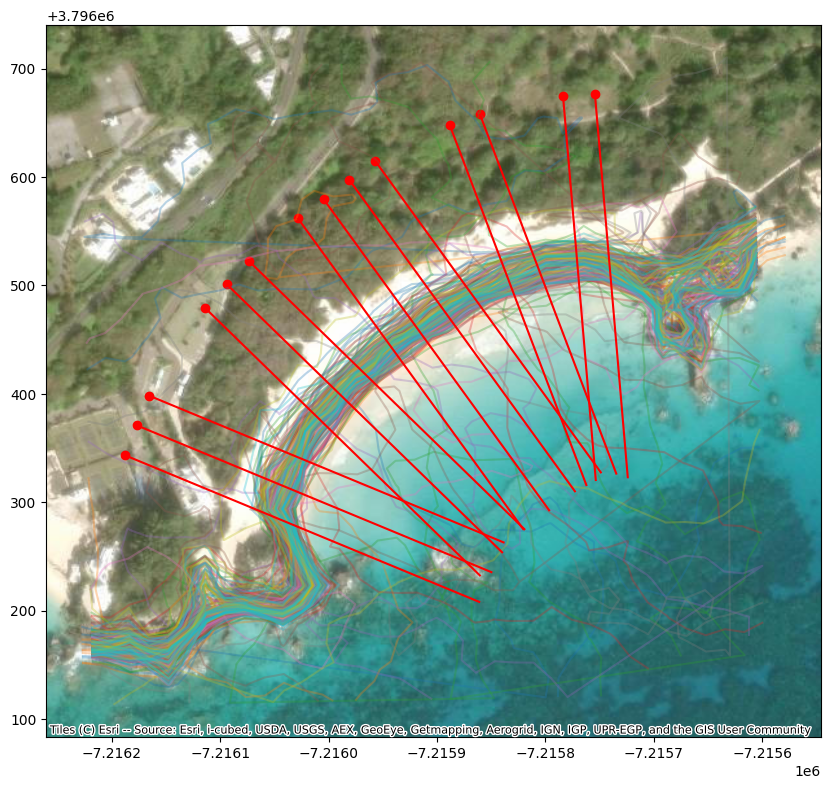

In [15]:
ax = gdf.to_crs(3857).plot("date", figsize=(10,10), alpha=.3)
transects_gdf.to_crs(3857).plot(ax=ax, color="red")
from shapely.geometry import Point
gpd.GeoSeries(transects_gdf.geometry.apply(lambda line: Point(line.coords[0])), crs=transects_gdf.crs).to_crs(3857).plot(ax=ax, color="red")
cx.add_basemap(ax, source=cx.providers.Esri.WorldImagery)
plt.show()

In [16]:
settings_transects = {  # parameters for computing intersections
    "along_dist": 25,  # along-shore distance to use for computing the intersection
    "min_points": 3,  # minimum number of shoreline points to calculate an intersection
    "max_std": 15,  # max std for points around transect
    "max_range": 30,  # max range for points around transect
    "min_chainage": -100,  # largest negative value along transect (landwards of transect origin)
    "multiple_inter": "auto",  # mode for removing outliers ('auto', 'nan', 'max')
    "auto_prc": 0.1,  # percentage of the time that multiple intersects are present to use the max
}
cross_distance = SDS_transects.compute_intersection_QC(
    output, transects, settings_transects
)

Computing transect shoreline intersections:   0%|          | 0/14 [00:00<?, ?it/s]

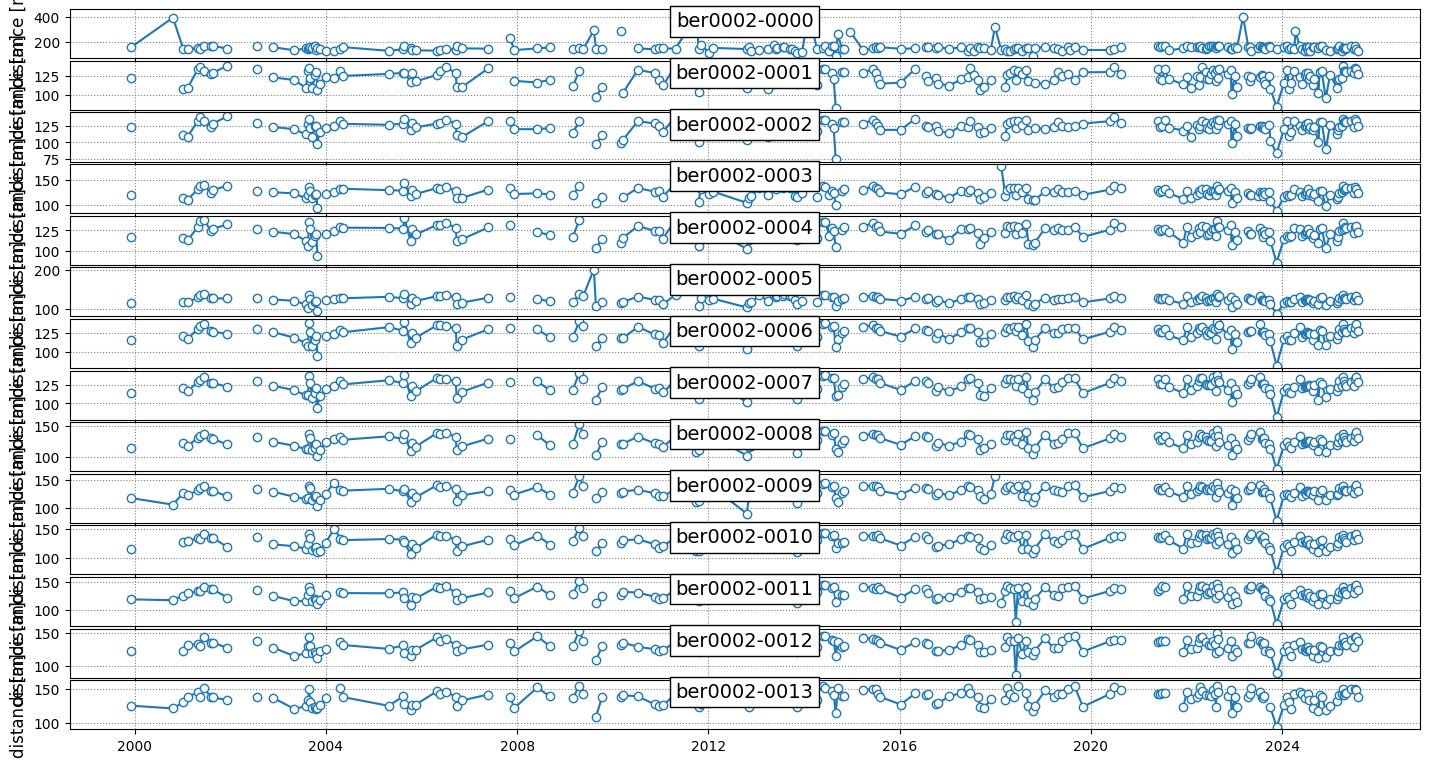

In [17]:
fig = plt.figure(figsize=[15, 8], tight_layout=True)
gs = gridspec.GridSpec(len(cross_distance), 1)
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.05)
for i, key in enumerate(cross_distance.keys()):
    if np.all(np.isnan(cross_distance[key])):
        continue
    ax = fig.add_subplot(gs[i, 0])
    ax.grid(linestyle=":", color="0.5")
    ax.plot(output["dates"], cross_distance[key], "-o", ms=6, mfc="w")
    ax.set_ylabel("distance [m]", fontsize=12)
    ax.text(
        0.5,
        0.95,
        key,
        bbox=dict(boxstyle="square", ec="k", fc="w"),
        ha="center",
        va="top",
        transform=ax.transAxes,
        fontsize=14,
    )
plt.show()

In [18]:
# save a .csv file for Excel users
out_dict = dict([])
out_dict["dates"] = output["dates"]
out_dict["satname"] = output["satname"]
for key in transects.keys():
    out_dict[key] = cross_distance[key]
df = pd.DataFrame(out_dict)
fn = os.path.join(
    settings["inputs"]["filepath"],
    settings["inputs"]["sitename"],
    "transect_time_series.csv",
)
df.to_csv(fn, sep=',', index=False)
print('Time-series of the shoreline change along the transects saved as:\n%s'%fn)
df

Time-series of the shoreline change along the transects saved as:
data/ber0002/transect_time_series.csv


dates satname  ber0002-0000  ber0002-0001  \
0   1999-12-04 14:45:40+00:00      L7    157.200282    123.134279   
1   2000-10-19 14:43:00+00:00      L7    392.296333           NaN   
2   2001-01-07 14:43:15+00:00      L7    141.473267    107.570156   
3   2001-02-08 14:43:13+00:00      L7    145.190659    109.277844   
4   2001-04-29 14:42:53+00:00      L7    148.805134    134.482566   
..                        ...     ...           ...           ...   
218 2025-06-26 14:52:33+00:00      L8           NaN           NaN   
219 2025-07-04 14:52:32+00:00      L9    140.754912    128.889964   
220 2025-07-12 14:52:36+00:00      L8    165.975044    135.524716   
221 2025-07-20 14:52:39+00:00      L9    146.611862    134.373955   
222 2025-08-05 14:52:46+00:00      L9    128.506123    127.968394   

     ber0002-0002  ber0002-0003  ber0002-0004  ber0002-0005  ber0002-0006  \
0      123.271126    119.693626    116.199225    113.716876    115.221956   
1             NaN           NaN           NaN           NaN           NaN   
2      111.086177    113.777986    115.004838    117.571780    120.177379   
3      109.026274    110.709228    112.682340    116.398703    117.170987   
4      132.851411    131.152385    129.451951    129.205274    130.457708   
..            ...           ...           ...           ...           ...   
218           NaN           NaN           NaN           NaN           NaN   
219    123.361394    122.871298    122.040514    121.729954    125.159084   
220    135.780138    134.771956    129.392722    129.523868    131.541670   
221    132.396060    131.637348    130.807104    132.399047    136.356121   
222    124.342067    123.408295    123.090046    123.263381    127.362842   

     ber0002-0007  ber0002-0008  ber0002-0009  ber0002-0010  ber0002-0011  \
0      114.588622    114.593758    117.827283    115.245071    119.116220   
1             NaN           NaN    106.176843           NaN    117.608421   
2      120.851420    123.118941    127.109179    126.623987    125.893499   
3      116.643110    117.483726    122.697423    128.354539    130.371131   
4      130.078637    131.118474    131.895087    134.259072    133.401805   
..            ...           ...           ...           ...           ...   
218           NaN           NaN           NaN           NaN           NaN   
219    123.986777    125.749069    127.056329    130.396602    130.070282   
220    134.125217    135.366436    137.890221    139.890567    141.178813   
221    136.878252    140.212399    140.855434    141.500391    143.819724   
222    129.402824    130.069604    130.116955    133.225787    135.800714   

     ber0002-0012  ber0002-0013  
0      122.601459    125.701050  
1             NaN    121.584346  
2      122.670221    130.562168  
3      131.426500    138.957860  
4      132.684994    145.126532  
..            ...           ...  
218           NaN           NaN  
219    127.831967           NaN  
220    142.956076    150.156796  
221    144.221721    149.026650  
222    137.686254    139.085039  

[223 rows x 16 columns]

In [19]:
handlers = pyfes.load_config("fes2022b/fes2022.yaml")

In [20]:
centroid = np.array(poly.geometry.centroid[0].coords[0])
# if longitude is negative add 180 (longitudes are from 0 to 360 in fes)
if centroid[0] < 0: centroid[0] += 360
centroid

array([295.17851517,  32.25179694])

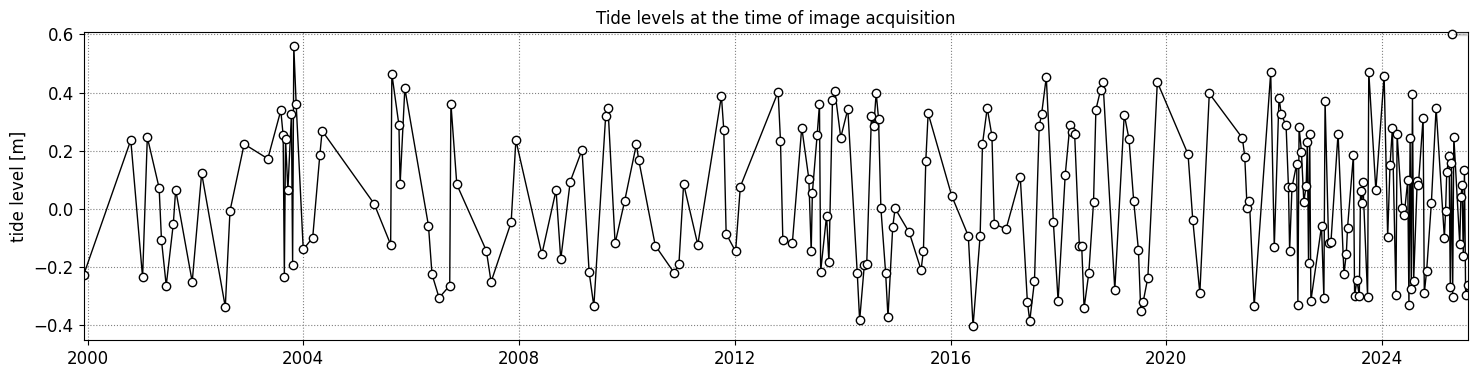

In [21]:
ocean_tide = handlers['tide']
load_tide = handlers['radial']
import SDS_slope

timestep = 900 # in seconds

# get tide levels corresponding to the time of image acquisition
dates_sat = output['dates']
tides_sat = SDS_slope.compute_tide_dates(centroid, output['dates'], ocean_tide, load_tide)
# plot the subsampled tide data
fig, ax = plt.subplots(1,1,figsize=(15,4), tight_layout=True)
ax.grid(which='major', linestyle=':', color='0.5')
ax.plot(dates_sat, tides_sat, '-o', color='k', ms=6, mfc='w',lw=1, label='image acquisition')
ax.set(ylabel='tide level [m]',xlim=[dates_sat[0],dates_sat[-1]], title='Tide levels at the time of image acquisition');
ax.legend()
filepath = os.path.join(inputs['filepath'], sitename)
fig.savefig(os.path.join(filepath,'%s_tide_timeseries.jpg'%sitename),dpi=200)
fig

In [22]:
tides = pd.DataFrame({'dates':dates_sat,'tide':tides_sat})
tides.to_csv(os.path.join(filepath,'tides.csv'),index=False)
tides

dates      tide
0   1999-12-04 14:45:40+00:00 -0.228315
1   2000-10-19 14:43:00+00:00  0.236625
2   2001-01-07 14:43:15+00:00 -0.235756
3   2001-02-08 14:43:13+00:00  0.246656
4   2001-04-29 14:42:53+00:00  0.072221
..                        ...       ...
218 2025-06-26 14:52:33+00:00  0.080873
219 2025-07-04 14:52:32+00:00 -0.160651
220 2025-07-12 14:52:36+00:00  0.134070
221 2025-07-20 14:52:39+00:00 -0.297415
222 2025-08-05 14:52:46+00:00 -0.262846

[223 rows x 2 columns]

In [23]:
df.index = pd.to_datetime(df.dates)
df.drop(columns=["dates", "satname"], inplace=True)

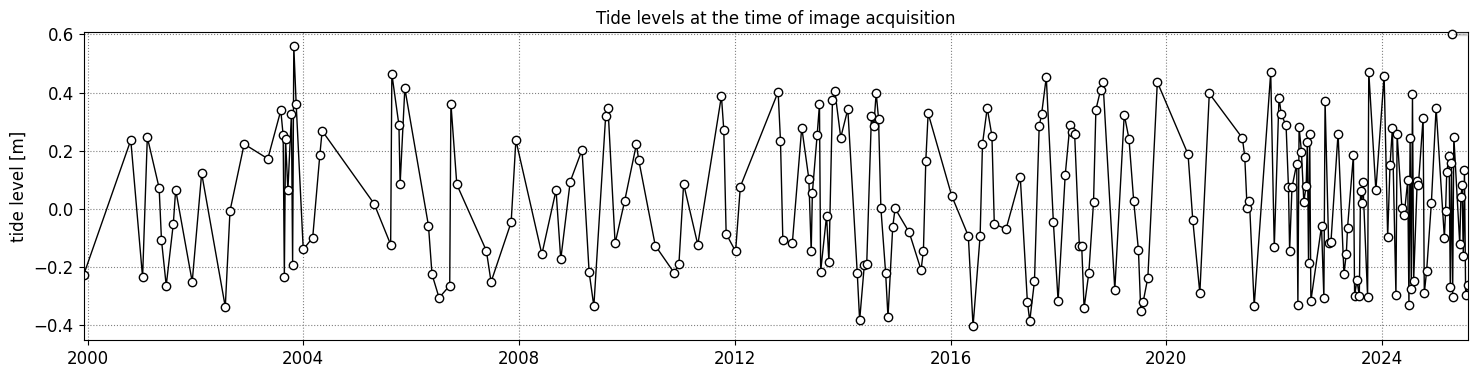

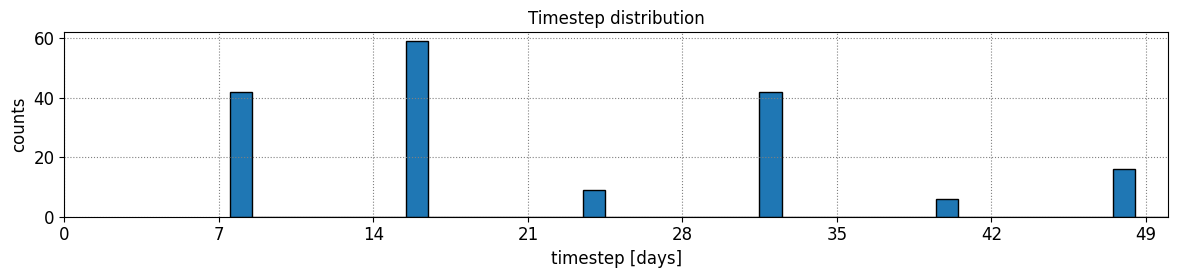

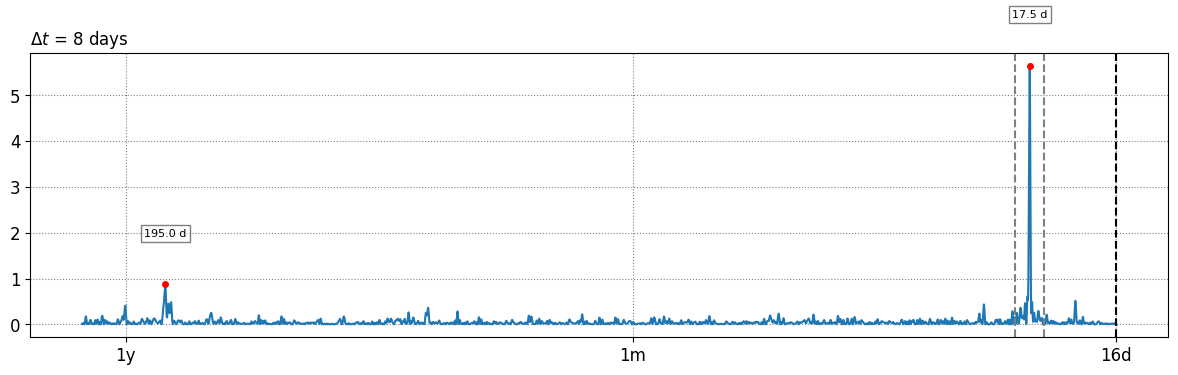

In [24]:
days_in_year = 365.2425
seconds_in_day = 24*3600
settings_slope = {'slope_min':        0.01,                  # minimum slope to trial
                  'slope_max':        0.2,                    # maximum slope to trial
                  'delta_slope':      0.005,                  # slope increment
                  'date_range':       [1999,2020],            # range of dates over which to perform the analysis
                  'n_days':           8,                      # sampling period [days]
                  'n0':               50,                     # parameter for Nyquist criterium in Lomb-Scargle transforms
                  'freqs_cutoff':     1./(seconds_in_day*30), # 1 month frequency
                  'delta_f':          100*1e-10,              # deltaf for identifying peak tidal frequency band
                  'prc_conf':         0.05,                   # percentage above minimum to define confidence bands in energy curve
                  }
settings_slope['date_range'] = [pytz.utc.localize(datetime(settings_slope['date_range'][0],5,1)),
                                pytz.utc.localize(datetime(settings_slope['date_range'][1],1,1))]
beach_slopes = SDS_slope.range_slopes(settings_slope['slope_min'], settings_slope['slope_max'], settings_slope['delta_slope'])

t = np.array([_.timestamp() for _ in df.index]).astype('float64')
delta_t = np.diff(t)
fig, ax = plt.subplots(1,1,figsize=(12,3), tight_layout=True)
ax.grid(which='major', linestyle=':', color='0.5')
bins = np.arange(np.min(delta_t)/seconds_in_day, np.max(delta_t)/seconds_in_day+1,1)-0.5
ax.hist(delta_t/seconds_in_day, bins=bins, ec='k', width=1);
ax.set(xlabel='timestep [days]', ylabel='counts',
      xticks=7*np.arange(0,20),
      xlim=[0,50], title='Timestep distribution');

# find tidal peak frequency (can choose 7 or 8 in this case)
settings_slope['n_days'] = 8
settings_slope['freqs_max'] = SDS_slope.find_tide_peak(df.index,tides.tide,settings_slope)
plt.show()

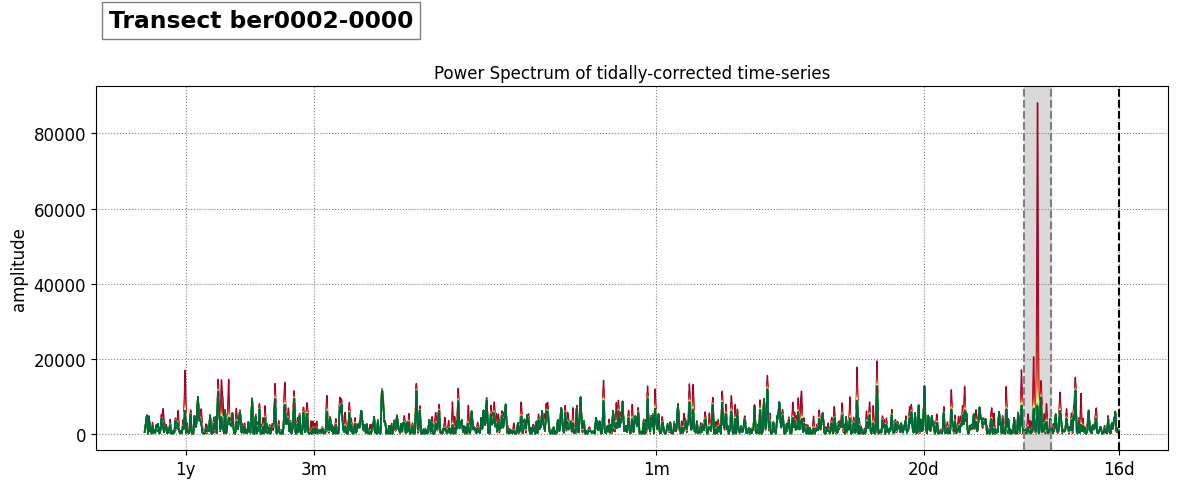

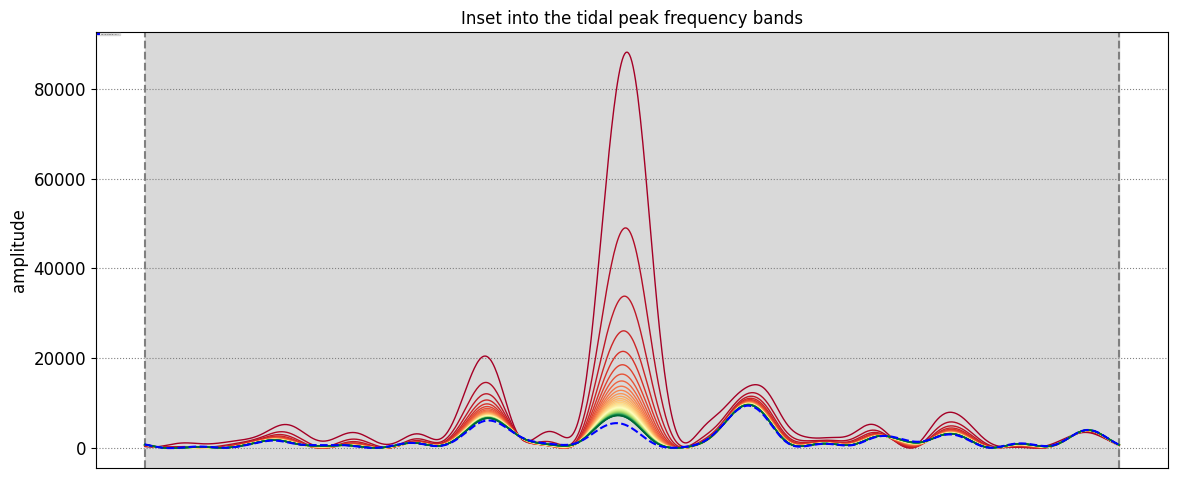

Beach slope at transect ber0002-0000: 0.200 (0.1101 - 0.2000)


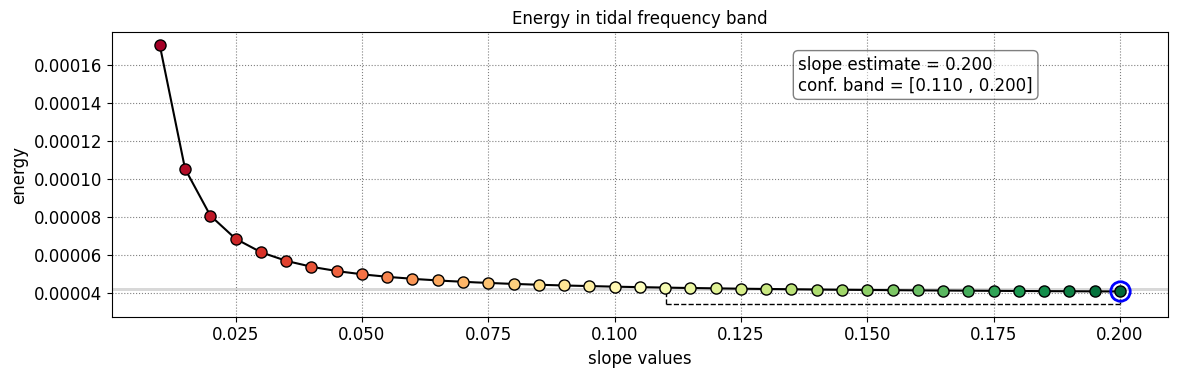

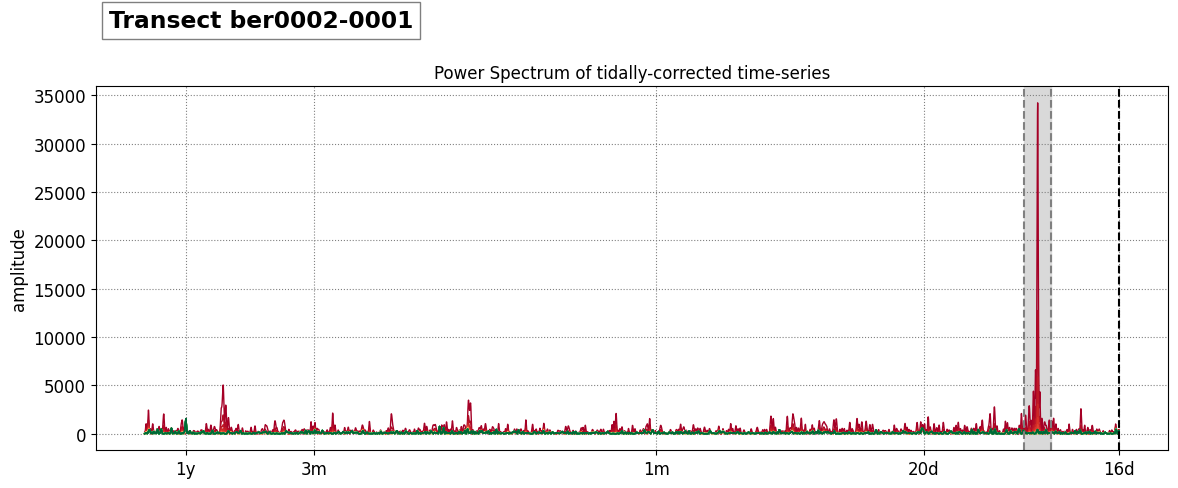

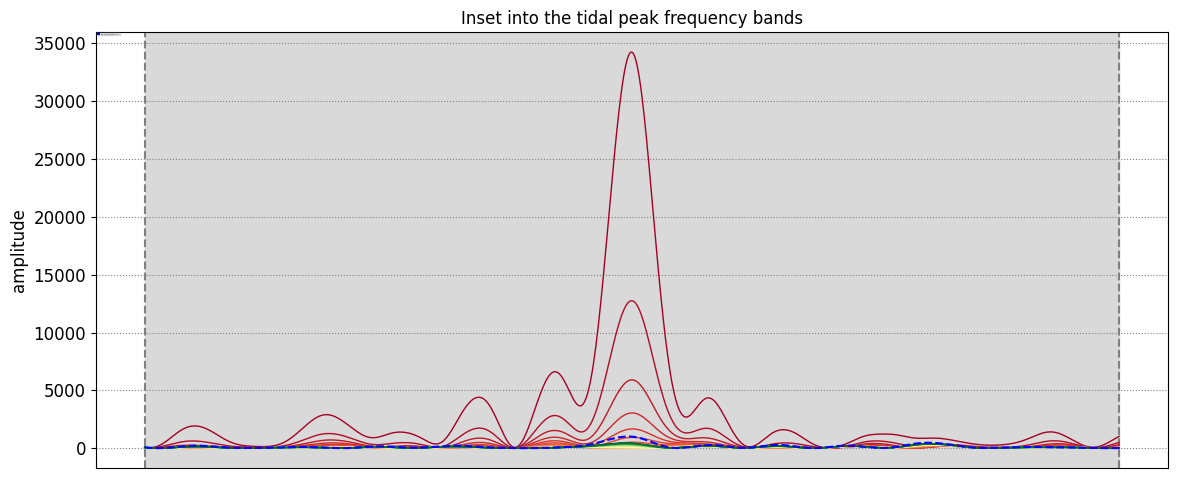

Beach slope at transect ber0002-0001: 0.070 (0.0574 - 0.0836)


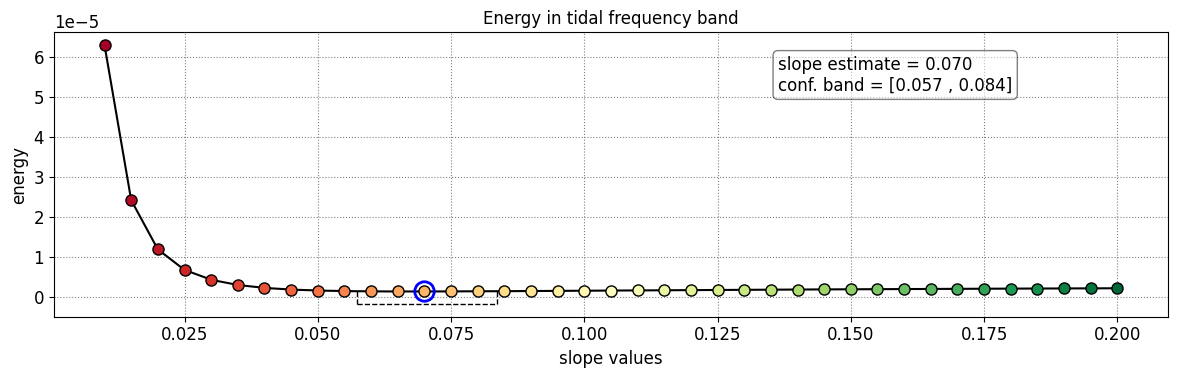

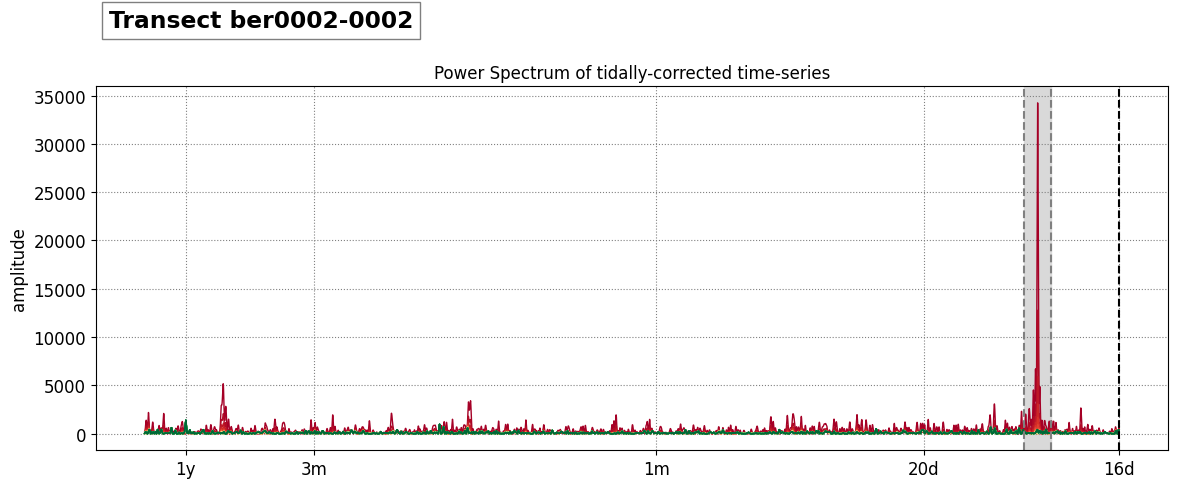

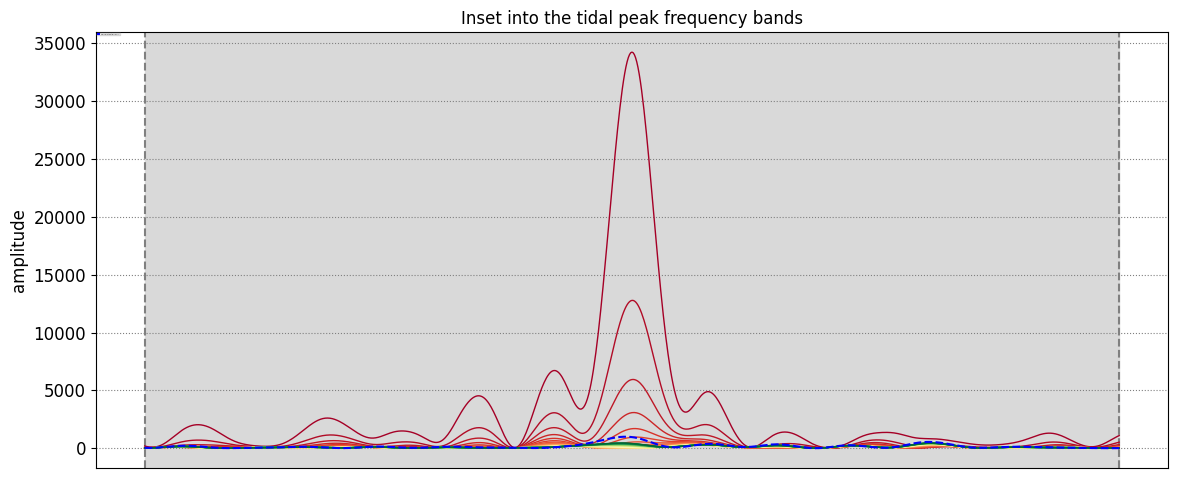

Beach slope at transect ber0002-0002: 0.070 (0.0573 - 0.0891)


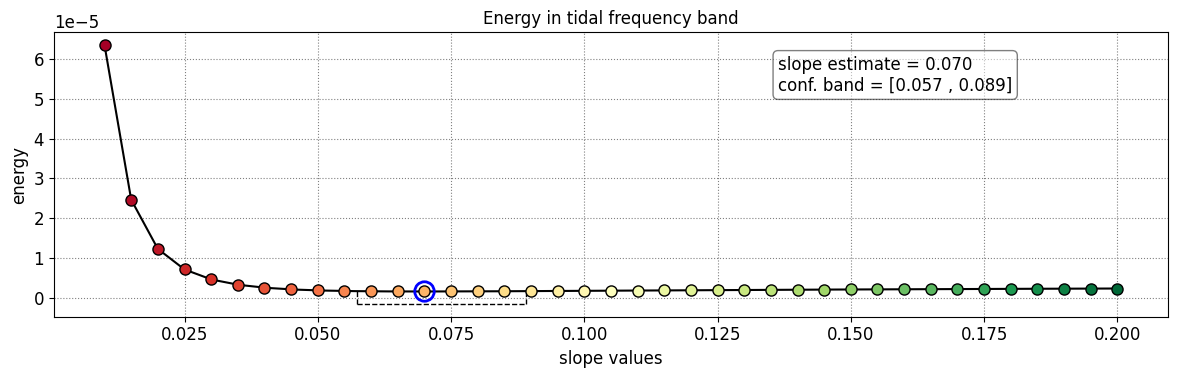

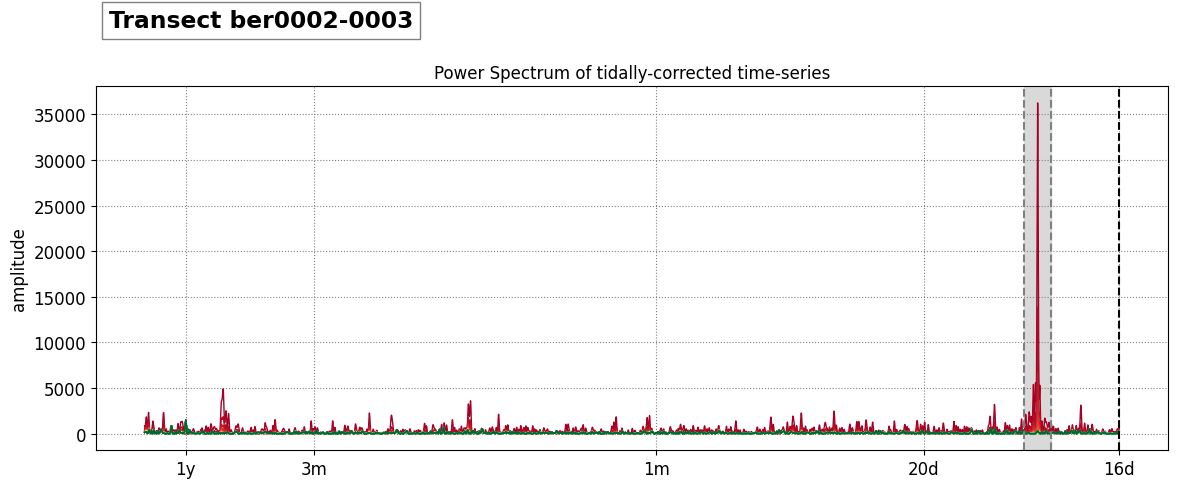

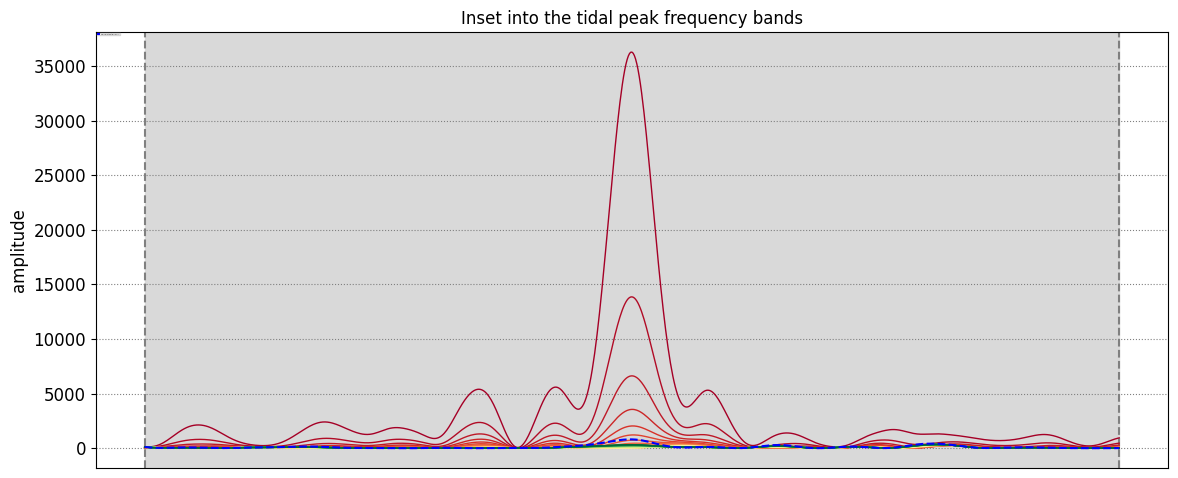

Beach slope at transect ber0002-0003: 0.085 (0.0684 - 0.1047)


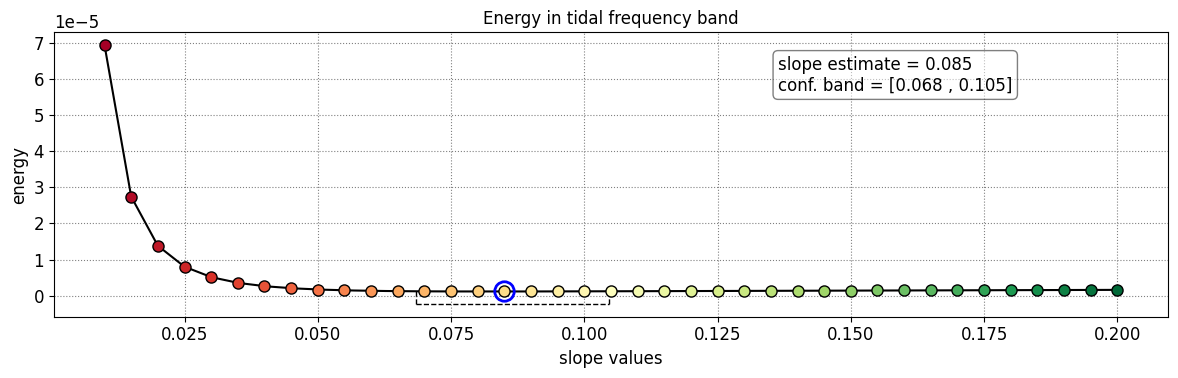

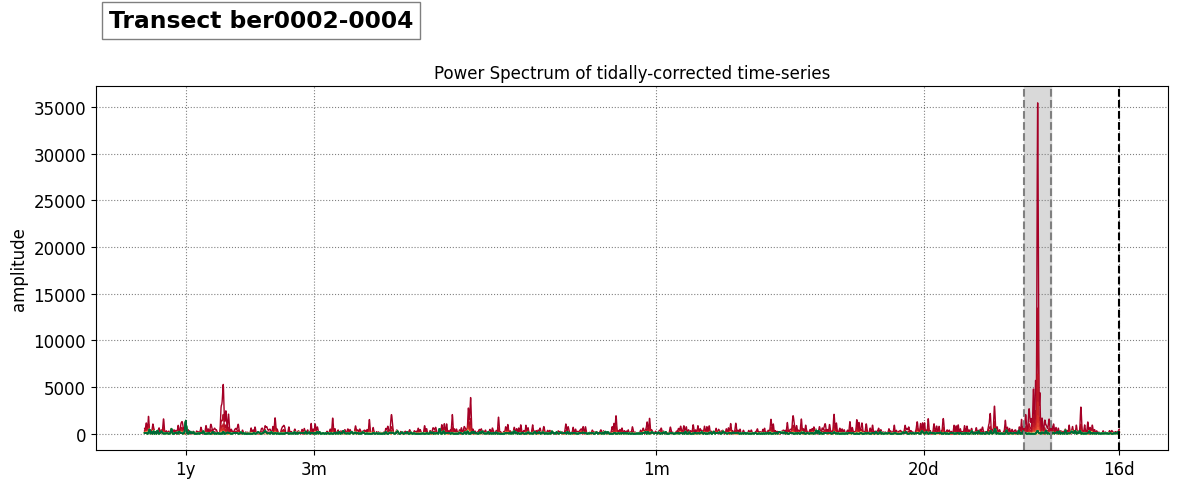

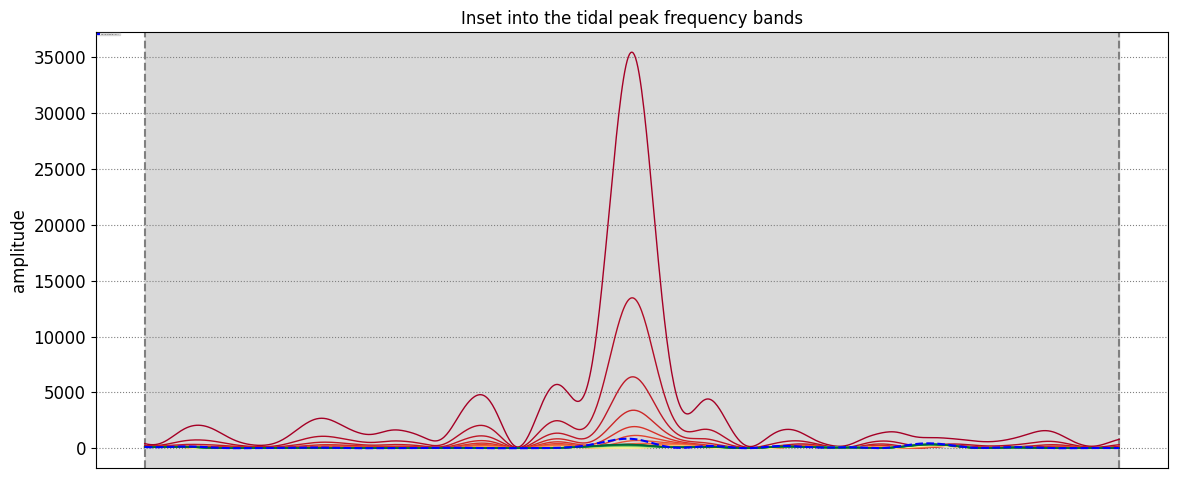

Beach slope at transect ber0002-0004: 0.080 (0.0682 - 0.0998)


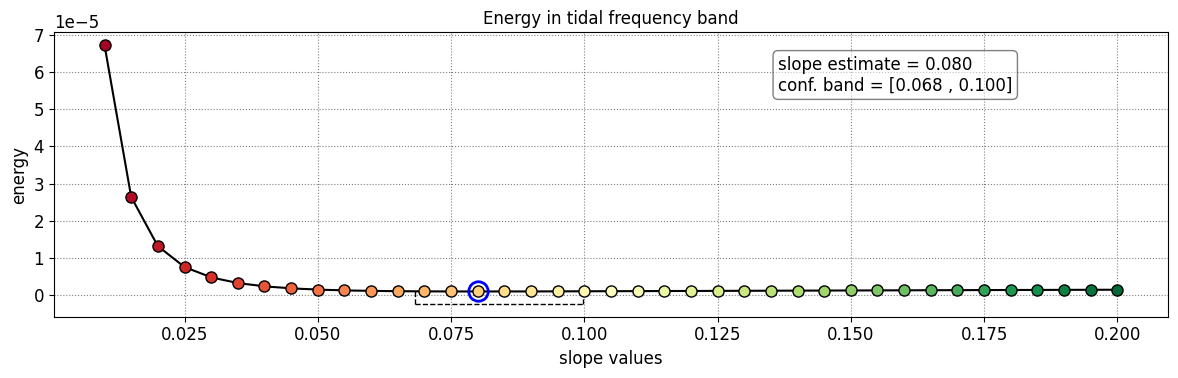

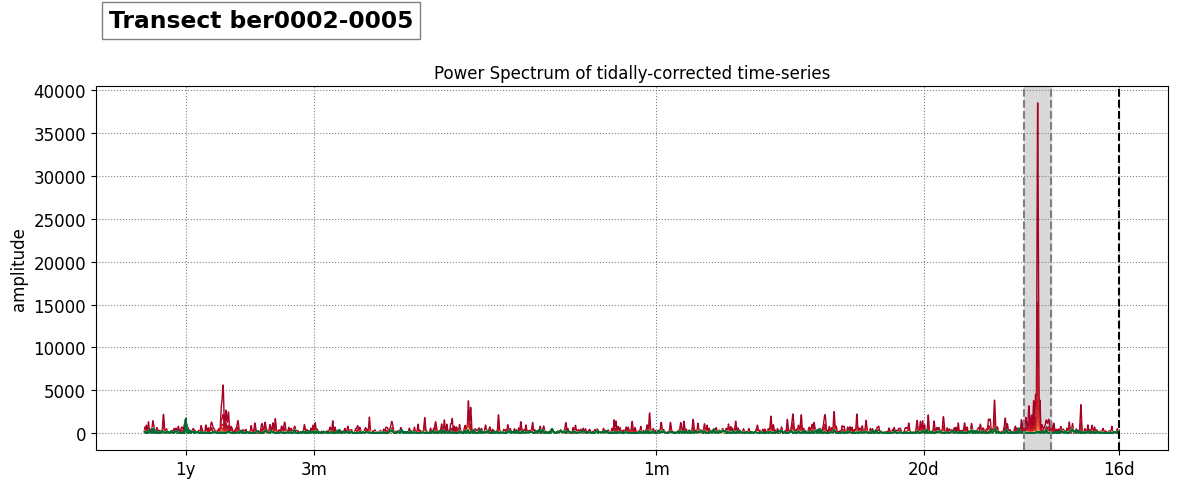

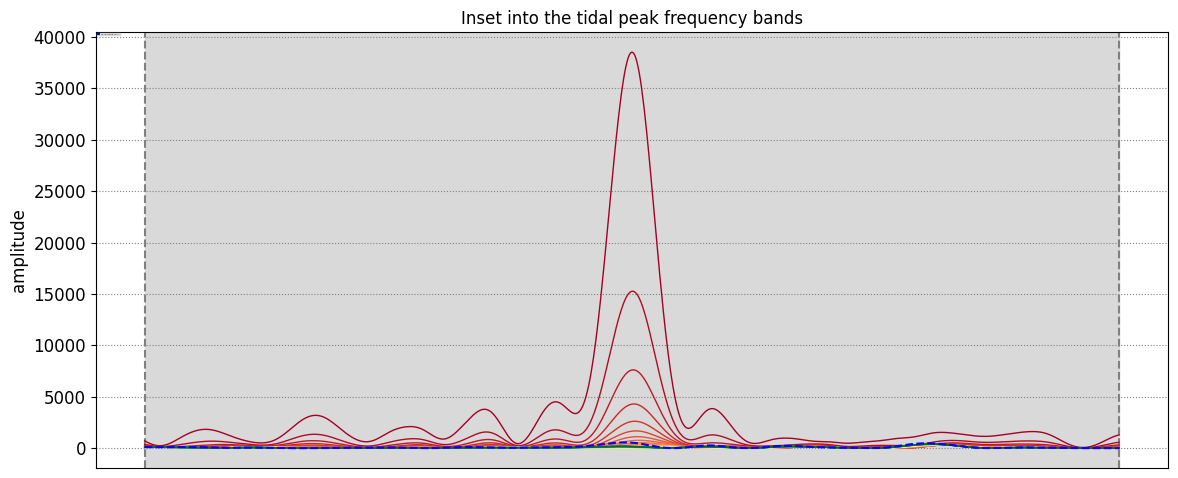

Beach slope at transect ber0002-0005: 0.090 (0.0740 - 0.1234)


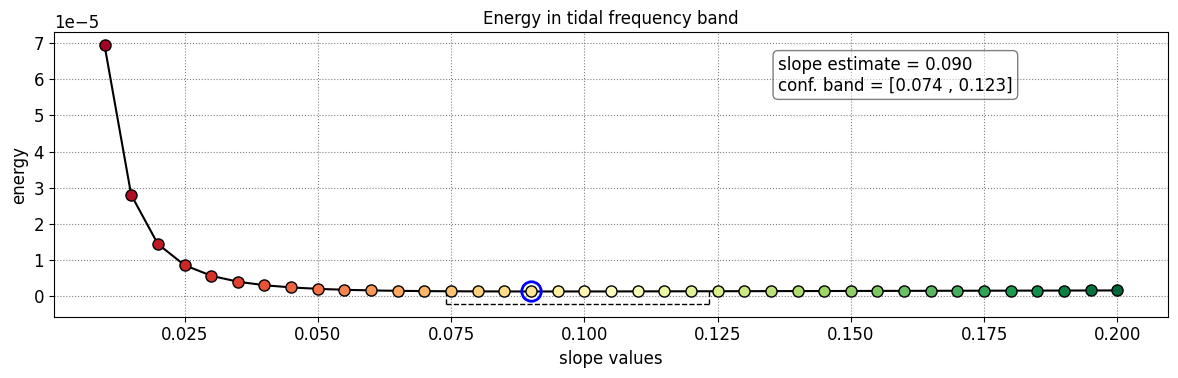

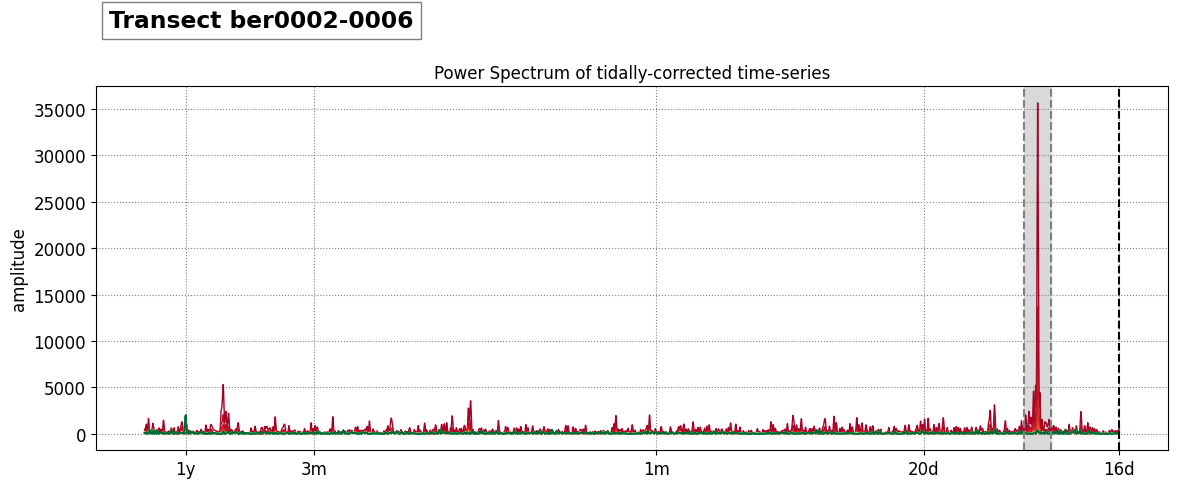

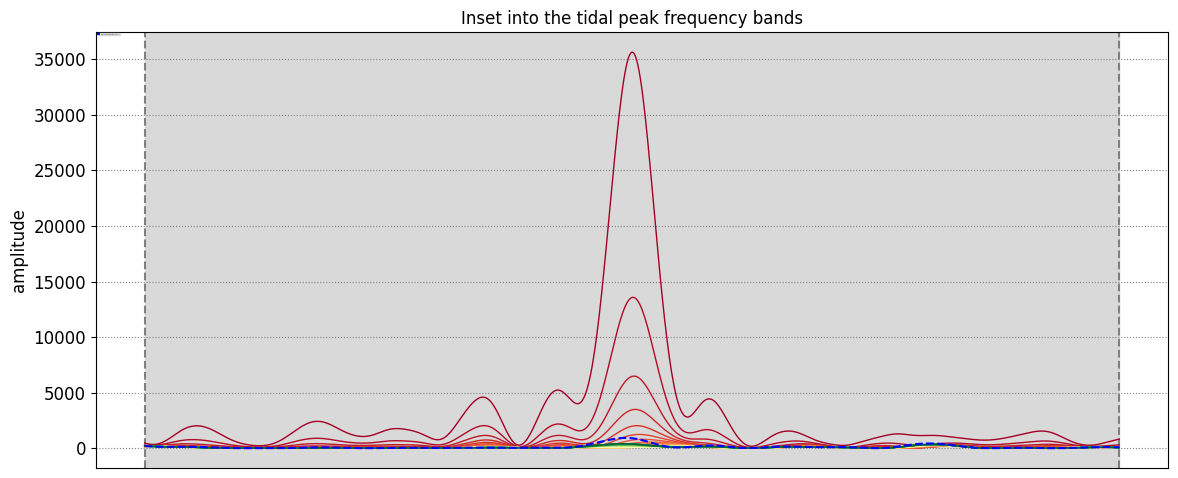

Beach slope at transect ber0002-0006: 0.080 (0.0662 - 0.1013)


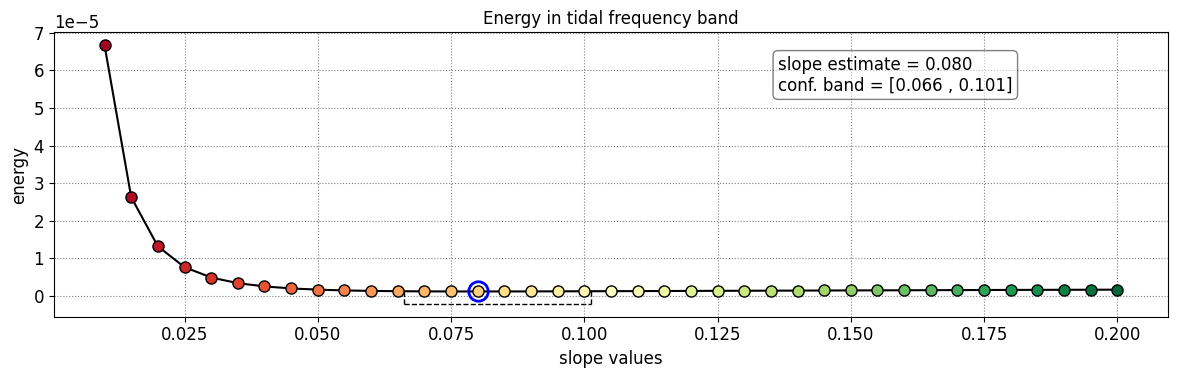

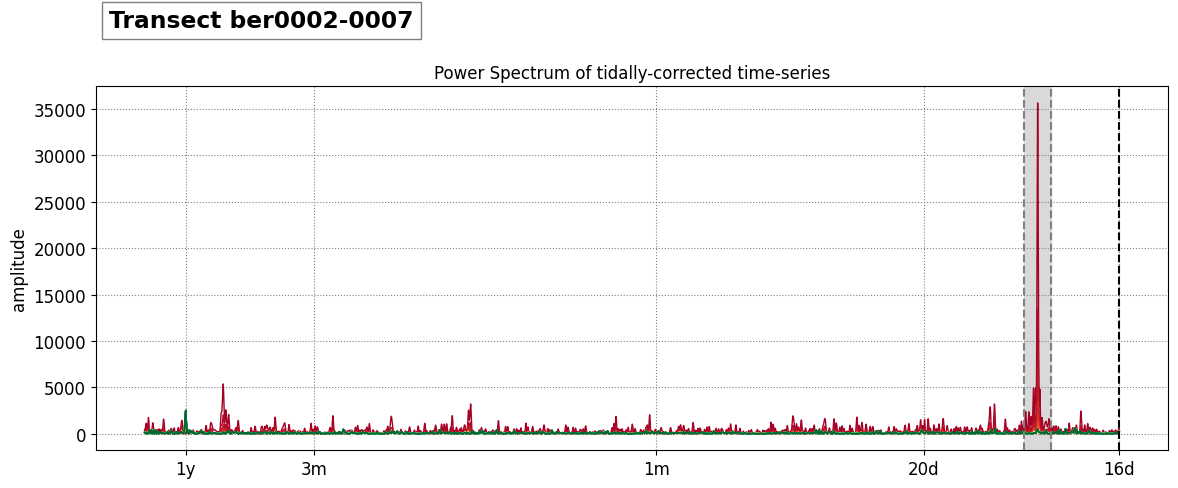

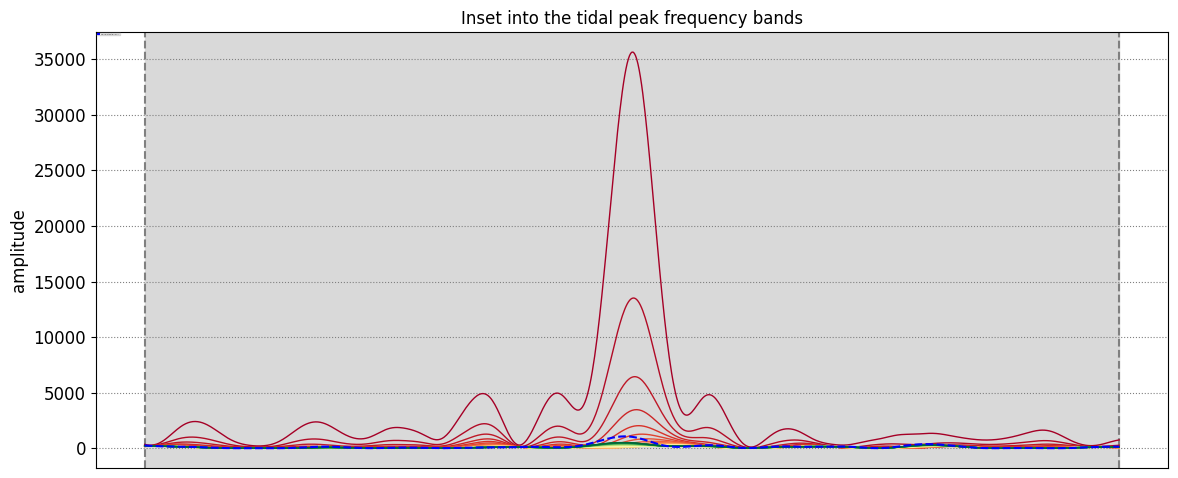

Beach slope at transect ber0002-0007: 0.080 (0.0634 - 0.1006)


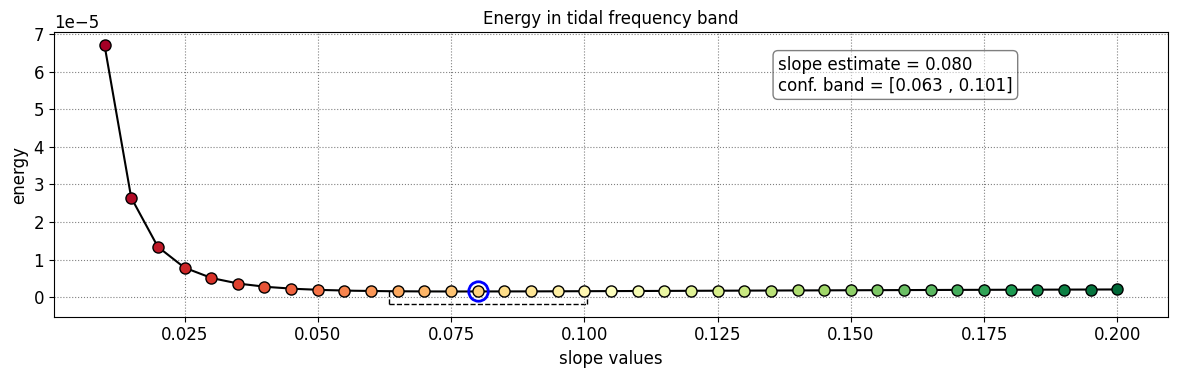

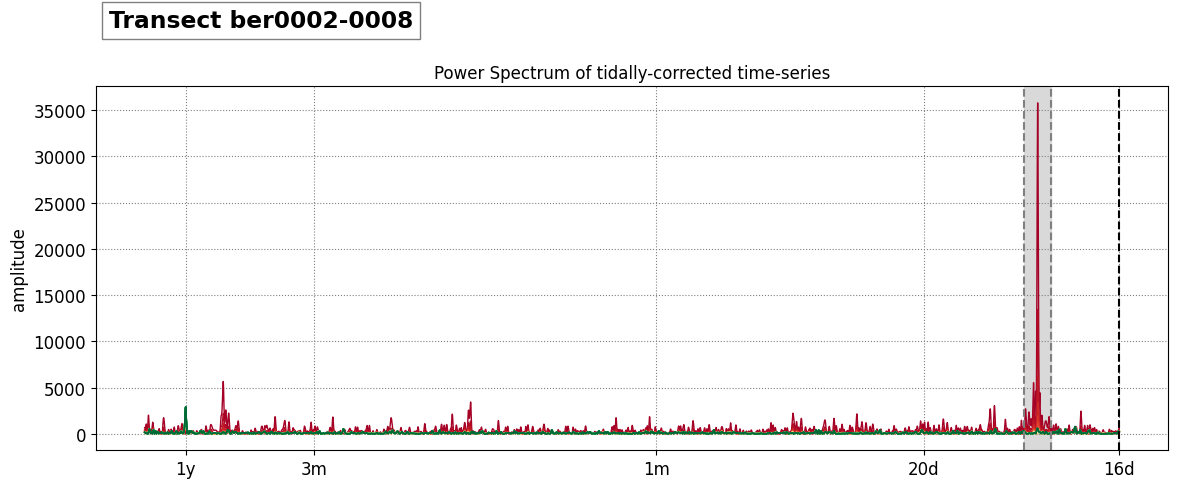

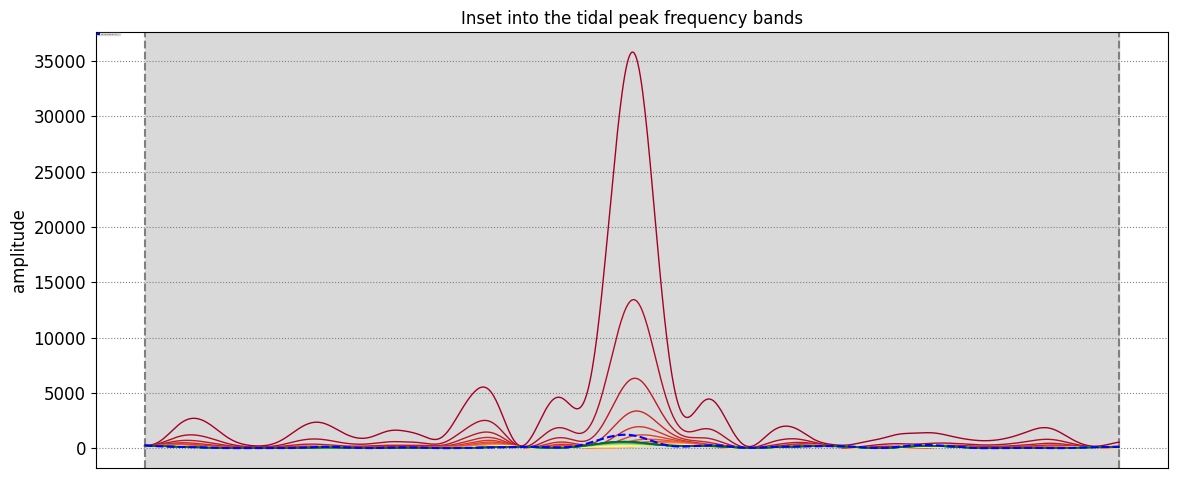

Beach slope at transect ber0002-0008: 0.075 (0.0627 - 0.1011)


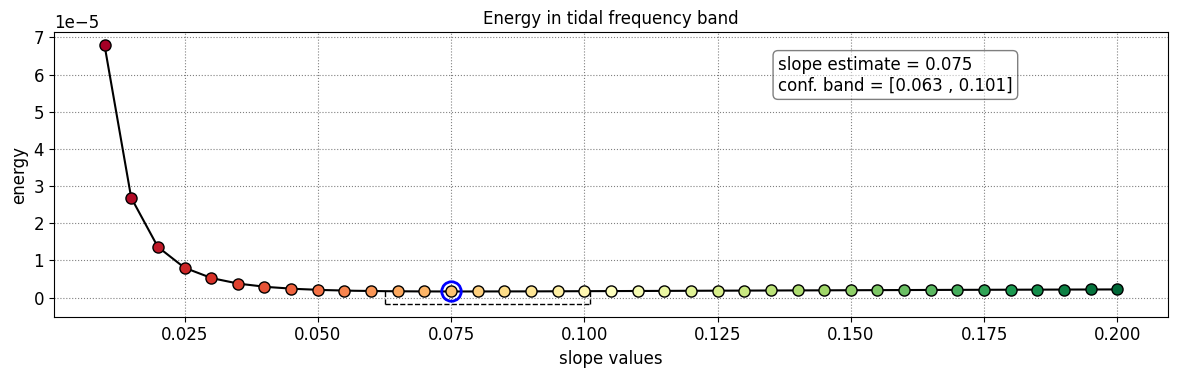

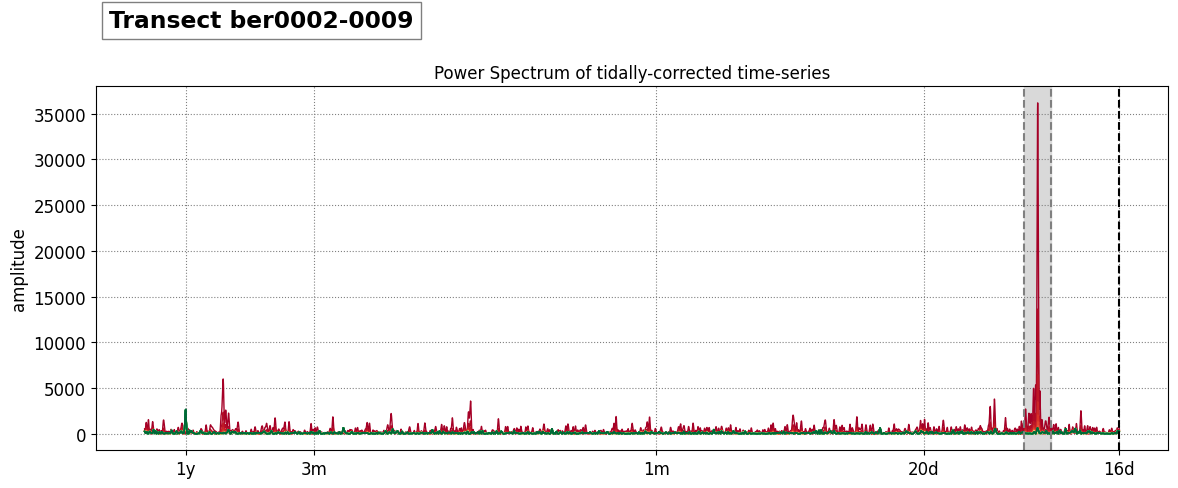

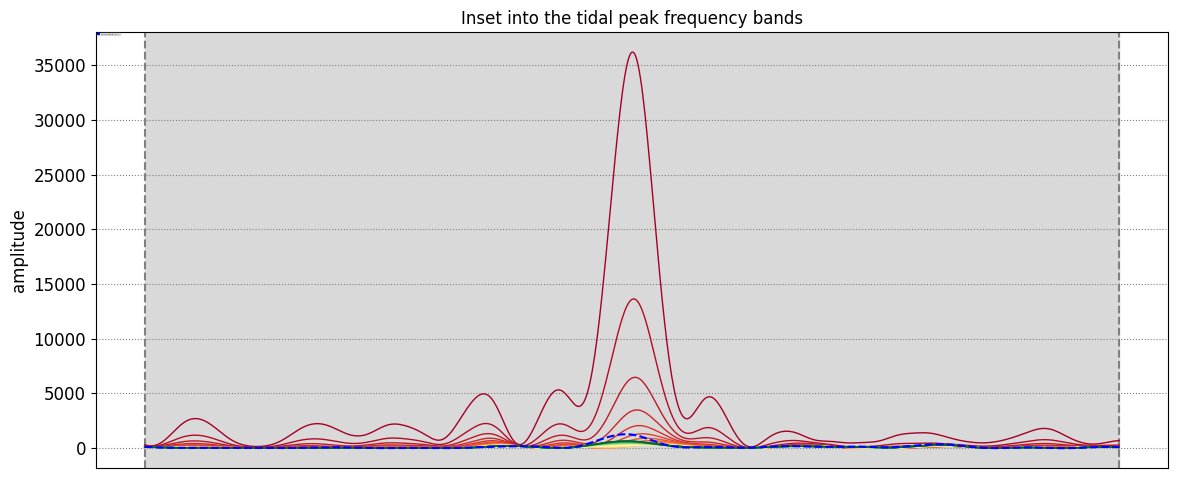

Beach slope at transect ber0002-0009: 0.080 (0.0638 - 0.1065)


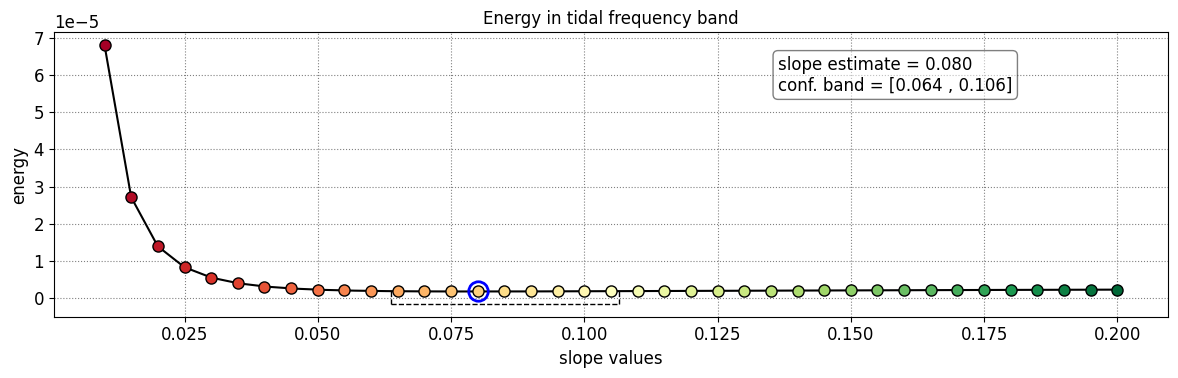

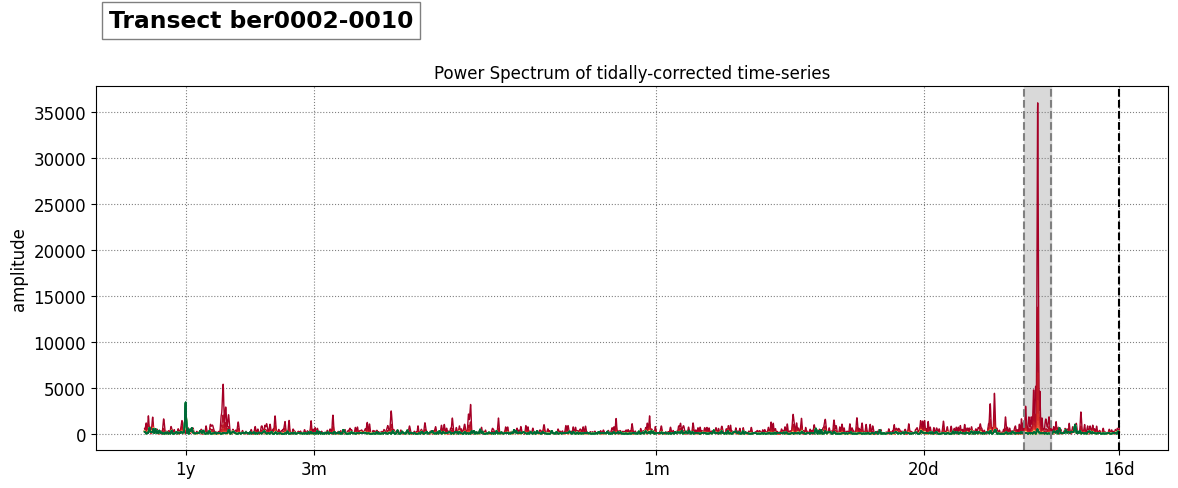

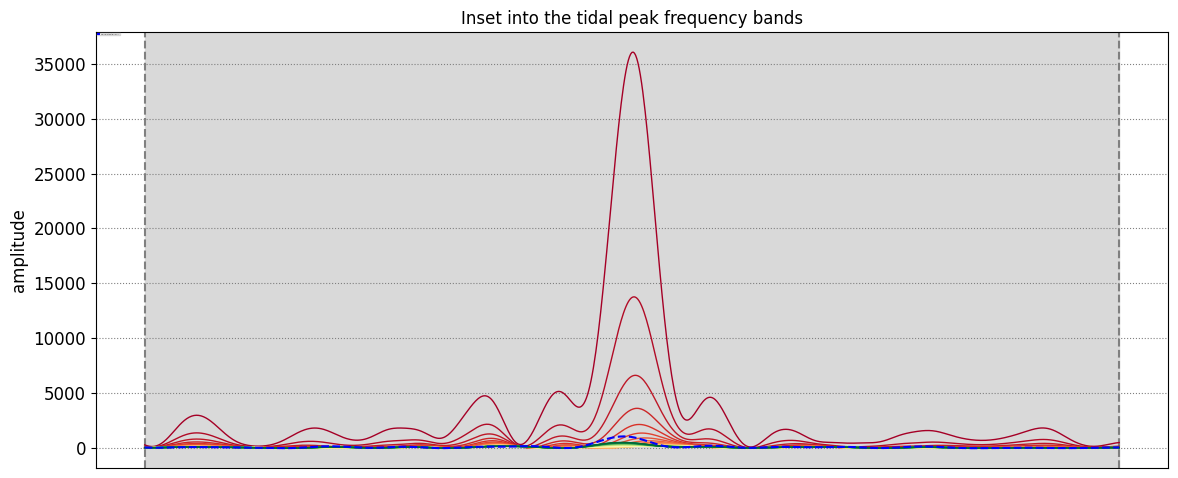

Beach slope at transect ber0002-0010: 0.085 (0.0673 - 0.1096)


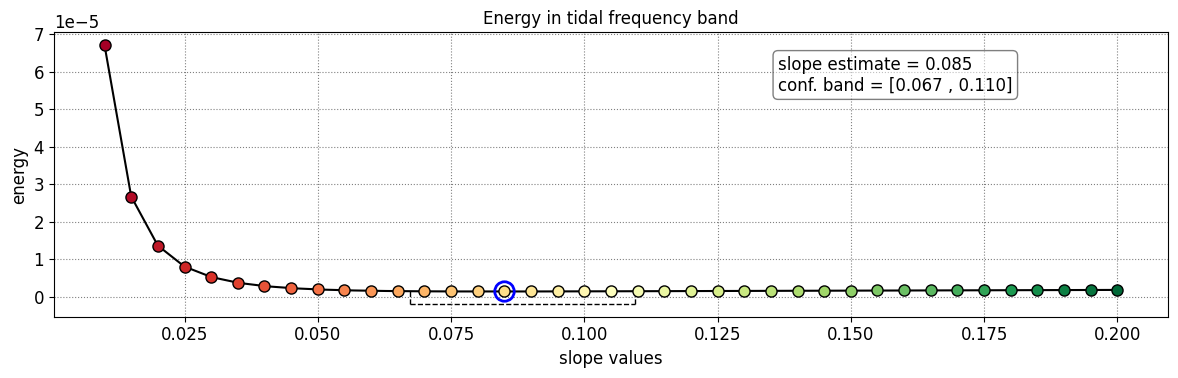

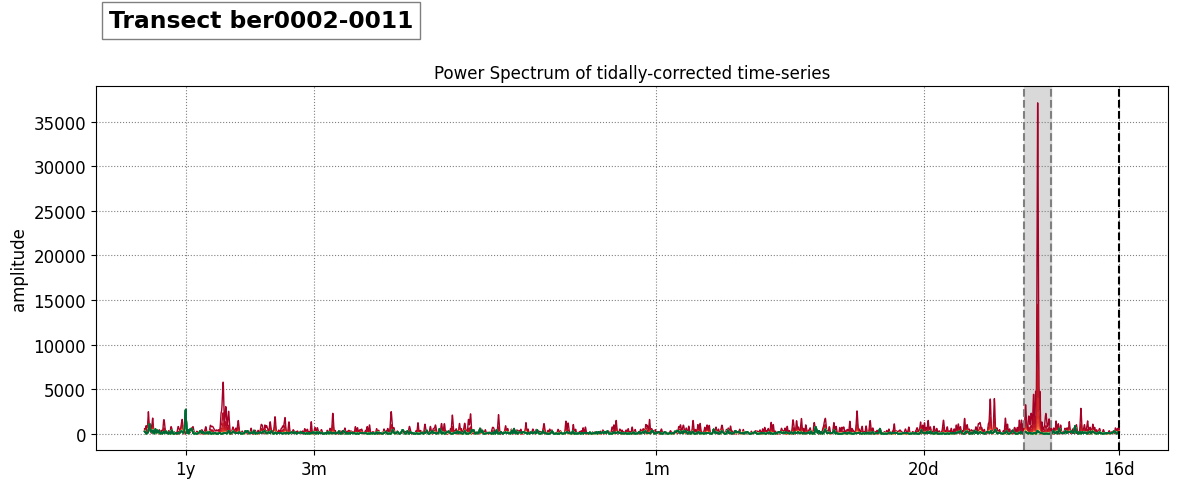

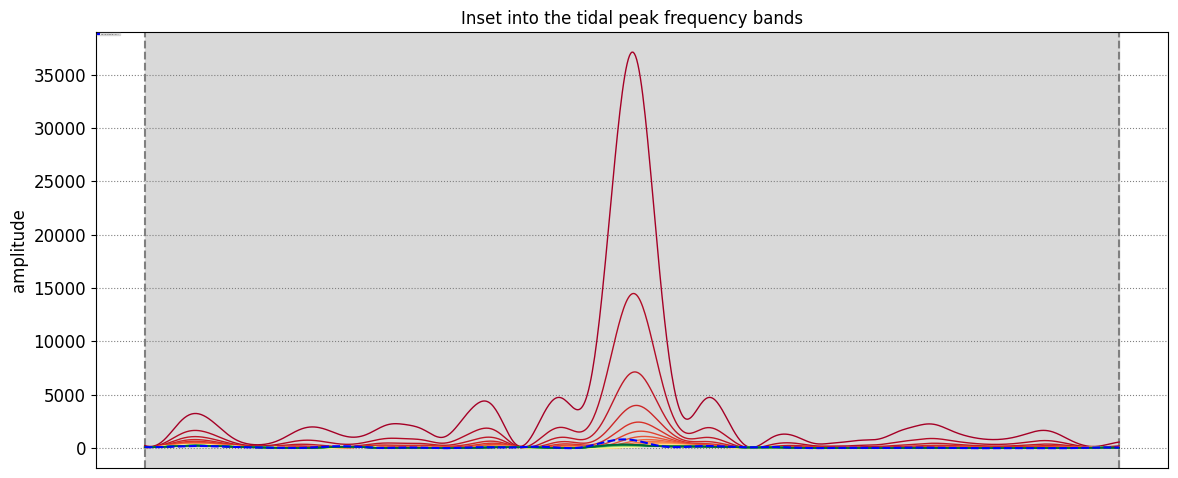

Beach slope at transect ber0002-0011: 0.105 (0.0797 - 0.1462)


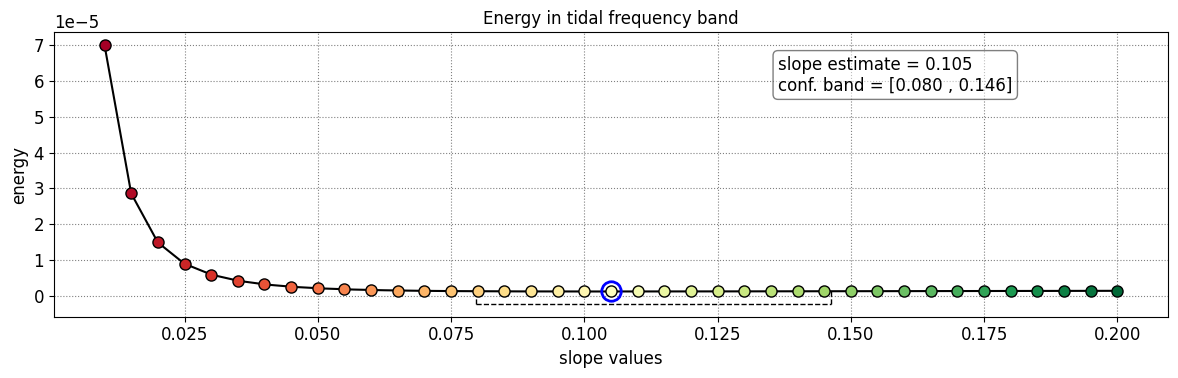

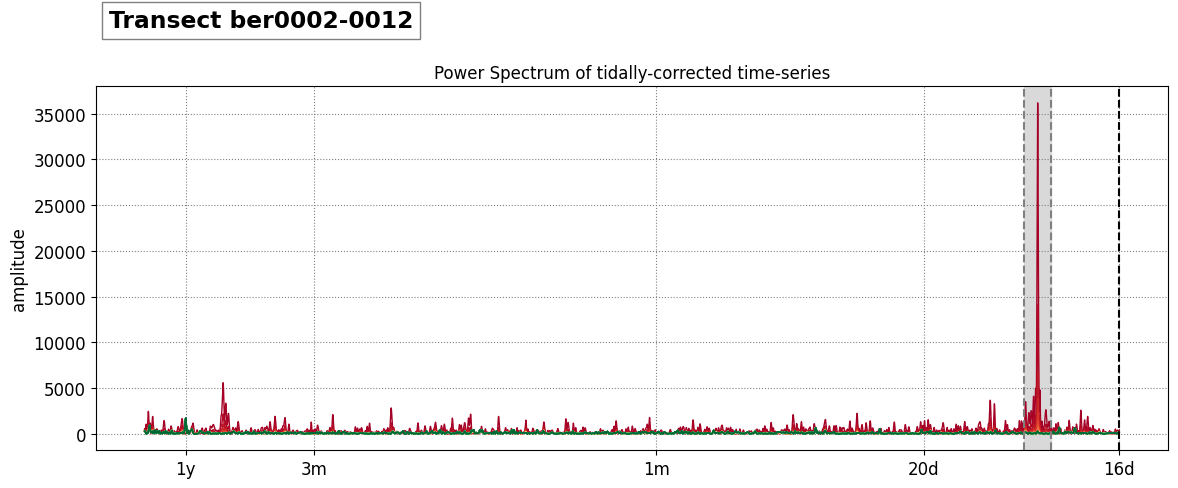

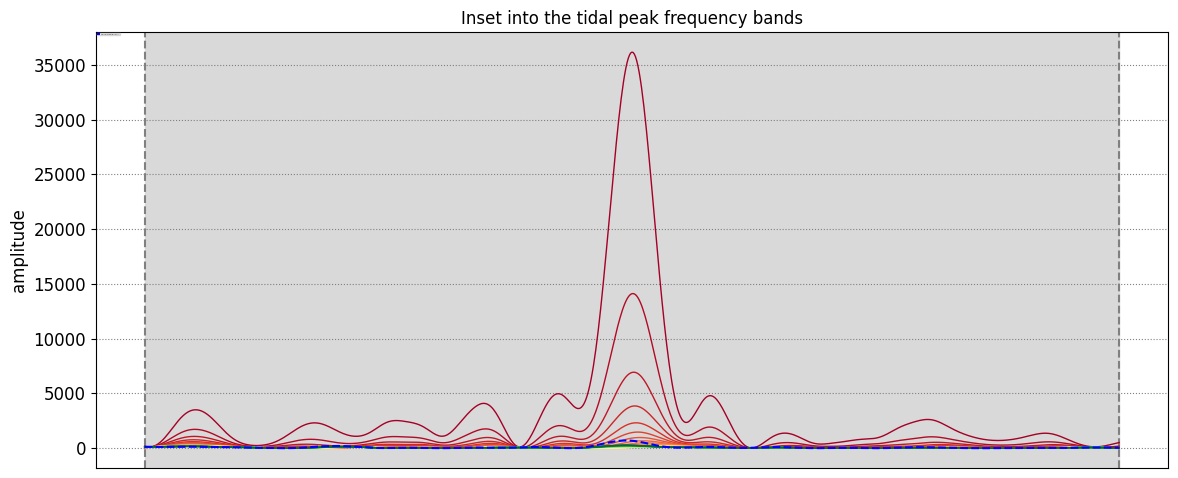

Beach slope at transect ber0002-0012: 0.105 (0.0835 - 0.1428)


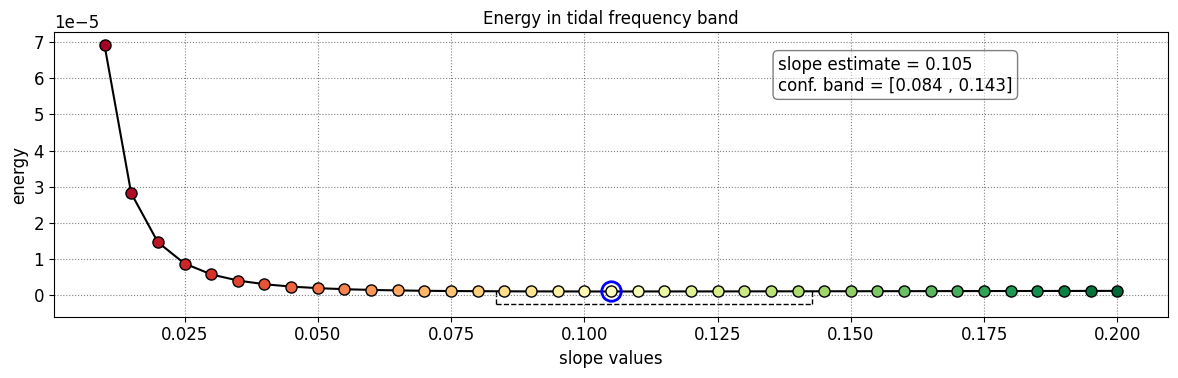

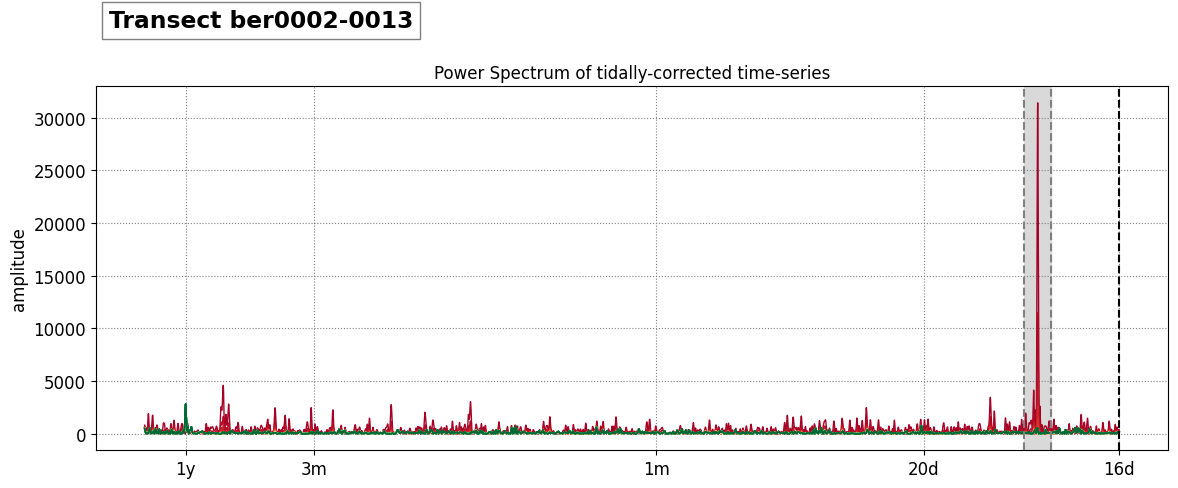

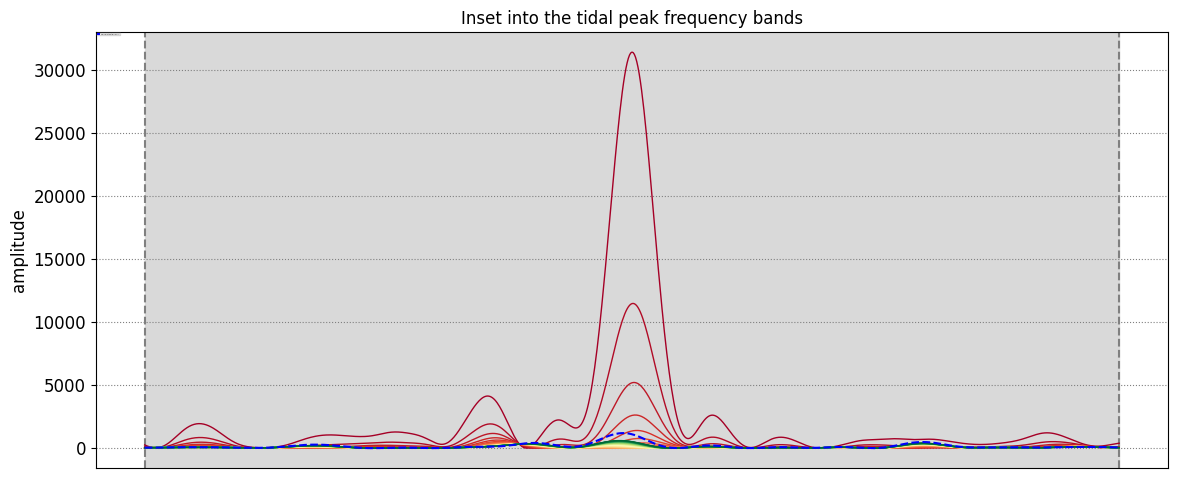

Beach slope at transect ber0002-0013: 0.055 (0.0491 - 0.0674)


In [25]:
# estimate beach-face slopes along the transects
slope_est, cis = dict([]), dict([])
for key in df.keys():
      # remove NaNs
      idx_nan = np.isnan(df[key])
      dates = [df.index[_] for _ in np.where(~idx_nan)[0]]
      tide = tides.tide.to_numpy()[~idx_nan]
      composite = df[key][~idx_nan]
      # apply tidal correction
      tsall = SDS_slope.tide_correct(composite,tide,beach_slopes)
      title = 'Transect %s'%key
      SDS_slope.plot_spectrum_all(dates,composite,tsall,settings_slope, title)
      plt.show()
      slope_est[key],cis[key] = SDS_slope.integrate_power_spectrum(dates,tsall,settings_slope)
      print('Beach slope at transect %s: %.3f (%.4f - %.4f)'%(key, slope_est[key], cis[key][0], cis[key][1]))

In [26]:
transects = gpd.read_file("transects_extended.geojson").set_index("id")
transects.beach_slope.update(slope_est)
transects.cil.update({k: v[0] for k,v in cis.items()})
transects.ciu.update({k: v[1] for k,v in cis.items()})
display(transects[transects.index.isin(slope_est.keys())])
transects.to_file("transects_extended.geojson")

site_id  orientation  along_dist  along_dist_norm  beach_slope  \
id                                                                             
ber0002-0000  ber0002          NaN         NaN              NaN        0.200   
ber0002-0001  ber0002          NaN         NaN              NaN        0.070   
ber0002-0002  ber0002          NaN         NaN              NaN        0.070   
ber0002-0003  ber0002          NaN         NaN              NaN        0.085   
ber0002-0004  ber0002          NaN         NaN              NaN        0.080   
ber0002-0005  ber0002          NaN         NaN              NaN        0.090   
ber0002-0006  ber0002          NaN         NaN              NaN        0.080   
ber0002-0007  ber0002          NaN         NaN              NaN        0.080   
ber0002-0008  ber0002          NaN         NaN              NaN        0.075   
ber0002-0009  ber0002          NaN         NaN              NaN        0.080   
ber0002-0010  ber0002          NaN         NaN              NaN        0.085   
ber0002-0011  ber0002          NaN         NaN              NaN        0.105   
ber0002-0012  ber0002          NaN         NaN              NaN        0.105   
ber0002-0013  ber0002          NaN         NaN              NaN        0.055   

                 cil     ciu     trend  n_points  n_points_nonan  r2_score  \
id                                                                           
ber0002-0000  0.1101  0.2000  0.224665     223.0           190.0  0.020157   
ber0002-0001  0.0574  0.0836 -0.097505     223.0           188.0  0.006084   
ber0002-0002  0.0573  0.0891 -0.045765     223.0           187.0  0.001488   
ber0002-0003  0.0684  0.1047 -0.129220     223.0           189.0  0.012803   
ber0002-0004  0.0682  0.0998 -0.079790     223.0           189.0  0.005916   
ber0002-0005  0.0740  0.1234 -0.034732     223.0           190.0  0.001127   
ber0002-0006  0.0662  0.1013  0.004886     223.0           190.0  0.000020   
ber0002-0007  0.0634  0.1006  0.025093     223.0           191.0  0.000483   
ber0002-0008  0.0627  0.1011  0.011266     223.0           193.0  0.000089   
ber0002-0009  0.0638  0.1065  0.088578     223.0           192.0  0.006440   
ber0002-0010  0.0673  0.1096  0.028300     223.0           190.0  0.000497   
ber0002-0011  0.0797  0.1462  0.057356     223.0           187.0  0.002423   
ber0002-0012  0.0835  0.1428 -0.010553     223.0           186.0  0.000081   
ber0002-0013  0.0491  0.0674  0.157248     223.0           177.0  0.014649   

                   mae         mse       rmse   intercept ERODIBILITY  \
id                                                                      
ber0002-0000  9.291492  138.937996  11.787196  145.439125        None   
ber0002-0001  7.326147   89.735897   9.472903  125.299373        None   
ber0002-0002  6.751371   81.858417   9.047564  125.112308        None   
ber0002-0003  6.567358   73.383543   8.566420  126.783486        None   
ber0002-0004  5.976532   60.872208   7.802064  124.573256        None   
ber0002-0005  6.066137   60.773925   7.795763  124.371637        None   
ber0002-0006  6.374614   67.021602   8.186672  124.961954        None   
ber0002-0007  6.816909   74.648560   8.639940  124.528243        None   
ber0002-0008  7.237888   81.192587   9.010693  126.144871        None   
ber0002-0009  6.645872   70.165869   8.376507  128.134846        None   
ber0002-0010  7.682399   92.744157   9.630377  128.837353        None   
ber0002-0011  7.512558   79.234887   8.901398  129.482491        None   
ber0002-0012  7.210548   79.289497   8.904465  131.010602        None   
ber0002-0013  7.547493   95.120607   9.752979  136.403294        None   

                                                       geometry  
id                                                               
ber0002-0000  LINESTRING (-64.82412 32.2513, -64.82117 32.25...  
ber0002-0001  LINESTRING (-64.82402 32.25151, -64.82107 32.2...  
ber0002-0002  LINESTRING (-64.82392 32.25172, -64.8

In [27]:
# remove outliers in the time-series (coastal despiking)
settings_outliers = {'max_cross_change':   40,             # maximum cross-shore change observable between consecutive timesteps
                     'otsu_threshold':     [-.5,0],        # min and max intensity threshold use for contouring the shoreline
                     'plot_fig':           True,           # whether to plot the intermediate steps
                    }
cross_distance = SDS_transects.reject_outliers(cross_distance,output,settings_outliers)

ber0002-0000  - outliers removed: 16
ber0002-0001  - outliers removed: 1
ber0002-0002  - outliers removed: 3
ber0002-0003  - outliers removed: 3
ber0002-0004  - outliers removed: 2
ber0002-0005  - outliers removed: 3
ber0002-0006  - outliers removed: 2
ber0002-0007  - outliers removed: 2
ber0002-0008  - outliers removed: 2
ber0002-0009  - outliers removed: 2
ber0002-0010  - outliers removed: 2
ber0002-0011  - outliers removed: 5
ber0002-0012  - outliers removed: 3
ber0002-0013  - outliers removed: 2


dates  ber0002-0000  ber0002-0001  ber0002-0002  \
0   1999-12-04 14:45:40+00:00           NaN    119.872631    120.009478   
1   2000-10-19 14:43:00+00:00           NaN           NaN           NaN   
2   2001-01-07 14:43:15+00:00    140.294489    104.202216    107.718237   
3   2001-02-08 14:43:13+00:00    146.423937    112.801495    112.549925   
4   2001-04-29 14:42:53+00:00    149.166240    135.514296    133.883141   
..                        ...           ...           ...           ...   
218 2025-06-26 14:52:33+00:00           NaN           NaN           NaN   
219 2025-07-04 14:52:32+00:00    139.951658    126.594954    121.066384   
220 2025-07-12 14:52:36+00:00    166.645396    137.440006    137.695428   
221 2025-07-20 14:52:39+00:00    145.124787    130.125169    128.147275   
222 2025-08-05 14:52:46+00:00    127.191891    124.213447    120.587120   

     ber0002-0003  ber0002-0004  ber0002-0005  ber0002-0006  ber0002-0007  \
0      117.007563    113.345283    111.180039    112.368014    111.734680   
1             NaN           NaN           NaN           NaN           NaN   
2      111.004389    112.057891    114.952272    117.230432    117.904474   
3      113.611058    115.765535    119.139320    120.254182    119.726305   
4      132.002045    130.354715    130.007730    131.360472    130.981400   
..            ...           ...           ...           ...           ...   
218           NaN           NaN           NaN           NaN           NaN   
219    120.981290    120.032380    119.944947    123.150950    121.978643   
220    136.349254    131.068601    131.013538    133.217549    135.801096   
221    128.138348    127.089417    129.094436    132.638434    133.160565   
222    120.315985    119.804468    120.342867    124.077264    126.117245   

     ber0002-0008  ber0002-0009  ber0002-0010  ber0002-0011  ber0002-0012  \
0      111.549553    114.973341    112.559008    116.941788    120.427027   
1             NaN    109.134652           NaN    119.861990           NaN   
2      119.975531    124.162232    123.850390    123.648206    120.424929   
3      120.772467    125.780618    131.256369    132.720232    133.775601   
4      132.081422    132.797851    135.108732    134.089625    133.372814   
..            ...           ...           ...           ...           ...   
218           NaN           NaN           NaN           NaN           NaN   
219    123.607059    125.048196    128.506594    128.540275    126.301961   
220    137.154040    139.566099    141.467865    142.455673    144.232936   
221    136.246866    137.137747    138.001391    140.987200    141.389197   
222    126.564987    126.831377    130.133478    133.297416    135.182956   

     ber0002-0013 satname  
0      121.549861      L7  
1      125.886613      L7  
2      126.275700      L7  
3      143.442507      L7  
4      146.439642      L7  
..            ...     ...  
218           NaN      L8  
219           NaN      L9  
220    152.594438      L8  
221    143.619105      L9  
222    134.306016      L9  

[223 rows x 16 columns]

Tidally-corrected time-series of the shoreline change along the transects saved as:
data/ber0002/transect_time_series_tidally_corrected.csv


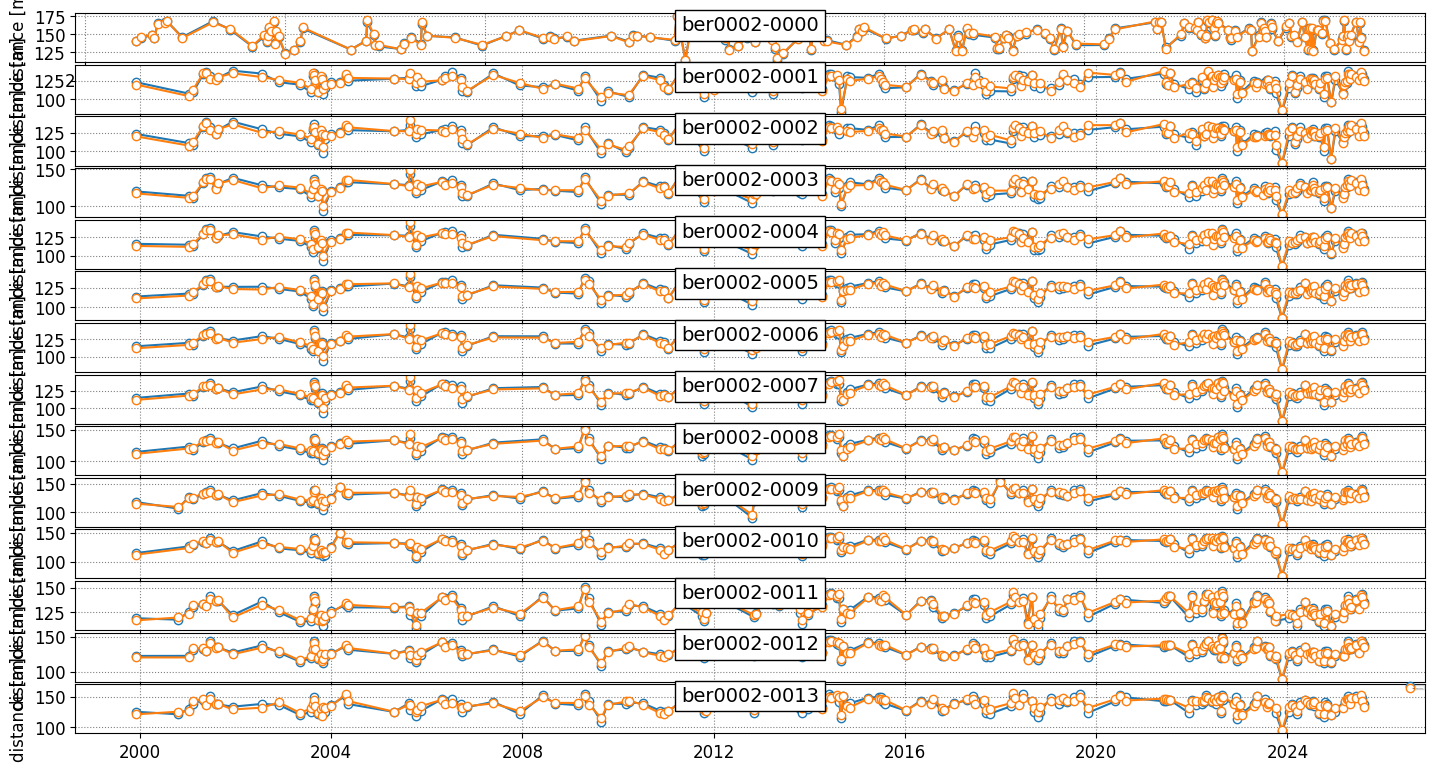

In [28]:
# tidal correction along each transect
cross_distance_tidally_corrected = {}
for key in cross_distance.keys():
    correction = (tides_sat)/slope_est[key]
    cross_distance_tidally_corrected[key] = cross_distance[key] + correction
    
# store the tidally-corrected time-series in a .csv file
out_dict = dict([])
out_dict['dates'] = dates_sat
for key in cross_distance_tidally_corrected.keys():
    out_dict[key] = cross_distance_tidally_corrected[key]
df = pd.DataFrame(out_dict)
df["satname"] = output["satname"]
display(df)
fn = os.path.join(filepath,'transect_time_series_tidally_corrected.csv')
df.to_csv(fn, sep=',', index=False)
print('Tidally-corrected time-series of the shoreline change along the transects saved as:\n%s'%fn)

# plot the time-series of shoreline change (both raw and tidally-corrected)
fig = plt.figure(figsize=[15,8], tight_layout=True)
gs = gridspec.GridSpec(len(cross_distance),1)
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.05)
for i,key in enumerate(cross_distance.keys()):
    if np.all(np.isnan(cross_distance[key])):
        continue
    idx_nan = np.isnan(cross_distance[key])
    dates = [output['dates'][_] for _ in np.where(~idx_nan)[0]]
    chainage = cross_distance[key][~idx_nan]
    chainage_corrected = cross_distance_tidally_corrected[key][~idx_nan]
    ax = fig.add_subplot(gs[i,0])
    ax.grid(linestyle=':', color='0.5')
    ax.plot(dates, chainage, '-o', ms=6, mfc='w', label='raw')
    ax.plot(dates, chainage_corrected, '-o', ms=6, mfc='w', label='tidally-corrected')
    ax.set_ylabel('distance [m]', fontsize=12)
    ax.text(0.5,0.95, key, bbox=dict(boxstyle="square", ec='k',fc='w'), ha='center',
            va='top', transform=ax.transAxes, fontsize=14)
ax.legend()
fig.savefig(os.path.join(filepath,'%s_timeseries_corrected.jpg'%sitename),dpi=200)
fig